# 1. Projekat iz predmeta Mašinsko učenje

Eye State Classification - EEG
https://www.kaggle.com/datasets/robikscube/eye-state-classification-eeg-dataset/data

Marija Cvetković 1940

Luka Kocić 2022

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold


In [26]:
df = pd.read_csv("input-eeg.csv")

## 1. Analiza podataka

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


In [28]:
df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


In [29]:
df['eyeDetection'].value_counts()

eyeDetection
0    8257
1    6723
Name: count, dtype: int64

Da bismo razumeli kako da izaberemo koje informacije želimo da uključimo u treniranje našeg model treba da znamo osnovne stvari o kolona koje imamo.
Opisi kolona:
Svaki od ovih parametara je električni signal sa određene pozicije na glavi meren u vremenu.

1. AF3 i AF4 se nalaze kod obrva i izuzetno su osetljivi na pokrete očiju. Kada se oko zatvori ili trepne trebalo bi da signal pravi veliki pik
2. F7 i F8 blizu očiju, levo i desno.
3. F3 i F4 takođe blizu očiju, ali ne koliko i prethodna dva
4. FC5 i FC6 mešavina frontalne i centralne aktivnosti
5. T7 i T8 nalaze se sa strane glave i ne bi trebalo toliko da utiču na treptaje, nalaze se daleko
6. P7 i P8 su senzorni regioni
7. O1 i O2 direktno vezani za vid, tako da bi trebalo da jako utiču.

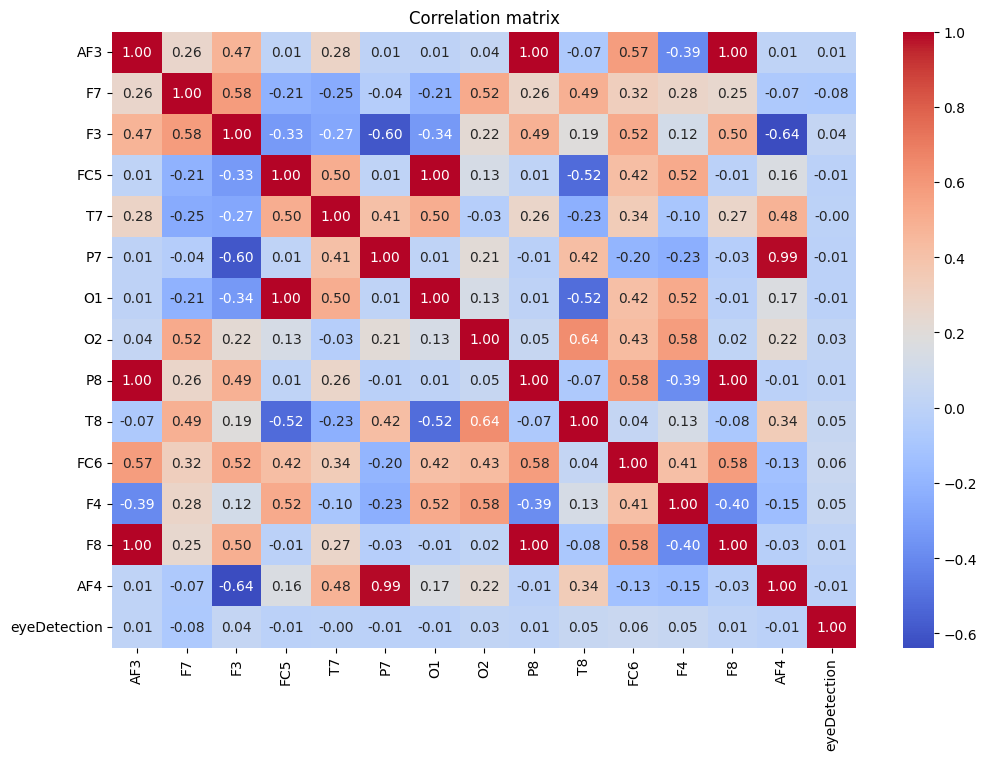

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

Na osnovu matrice korelacije možemo da zaključimo sledeće:
1. EyeDetection kolona prema matrici korelacije trenutno nema linearnu vezu sa ostalim kanalima sve vrednosti su izmedju 0.00 i -0.06 (jer je eyeDetection boolean)

2. Postoje visoke korelacije izmedju AF3 i F8 (1.00), AF3 i P8 (1.00), FC5 i O1 (1.00), PC8 i F8 (1.00)  kao i izmedju P7 i AF4(0.99). Imamo duplirane podatke što znači da model može da bude nestabilan. Možemo da izbacimo jednu kolonu iz svakog od navedenih parova.

Za izbor kolone za isključivanje biće korišćena point-beserial korelacija sa eyeDetection kolonom:

In [31]:
from scipy.stats import pointbiserialr

for col in df.select_dtypes(include='number'):
    corr, p_value = pointbiserialr(df["eyeDetection"], df[col])
    print(f"{col}: {abs(corr):.4f}")

AF3: 0.0105
F7: 0.0800
F3: 0.0389
FC5: 0.0075
T7: 0.0004
P7: 0.0078
O1: 0.0072
O2: 0.0251
P8: 0.0096
T8: 0.0472
FC6: 0.0643
F4: 0.0480
F8: 0.0131
AF4: 0.0075
eyeDetection: 1.0000


## 2. Deskriptivna analiza i čišćenje podataka

In [32]:
df.isnull().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

In [33]:
df.duplicated().any()

np.False_

In [34]:
df = df.drop_duplicates()

### Detekcija outlier-a


Box plot nad svim numerickim podacima

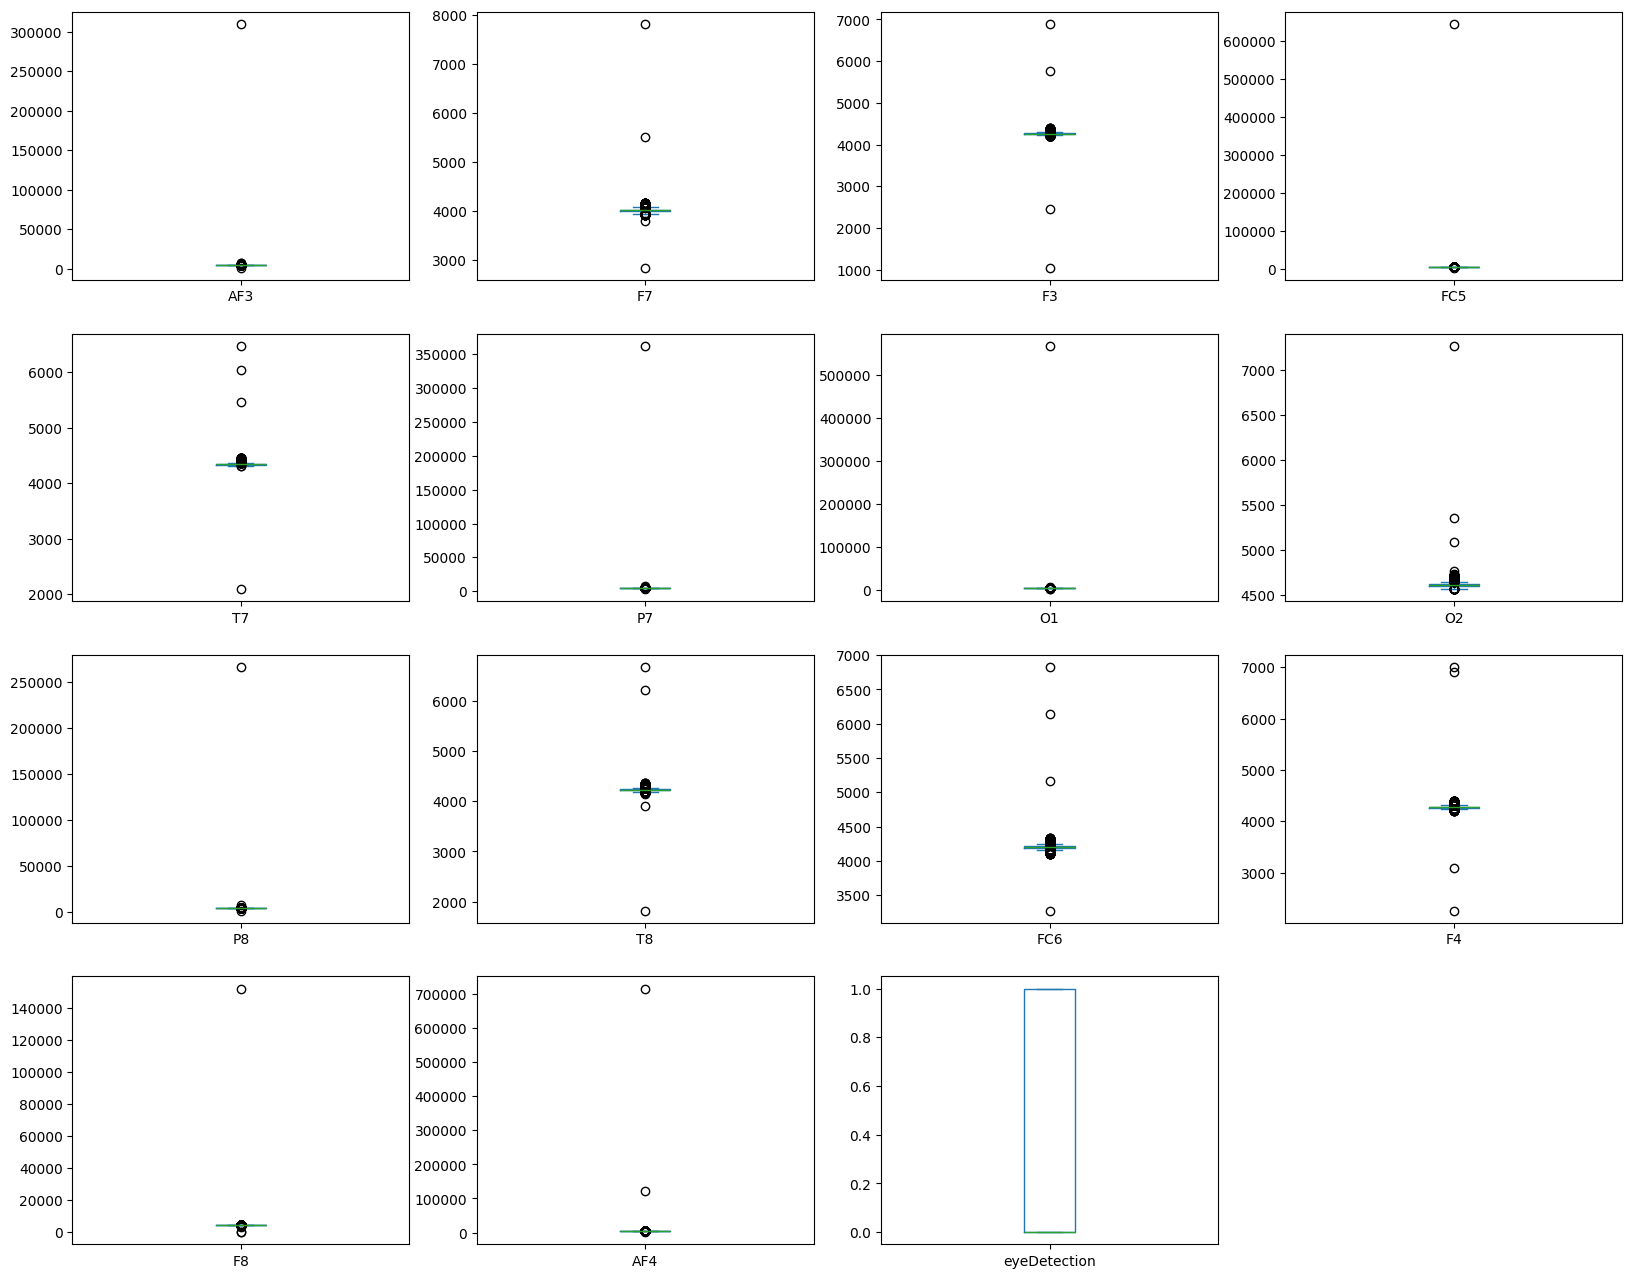

In [35]:
number_columns = df.select_dtypes(include='number')
number_columns.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))
plt.show()

Vizualizacija outlier-a pomoću boxplot-a, scatter plot-a i histograma:

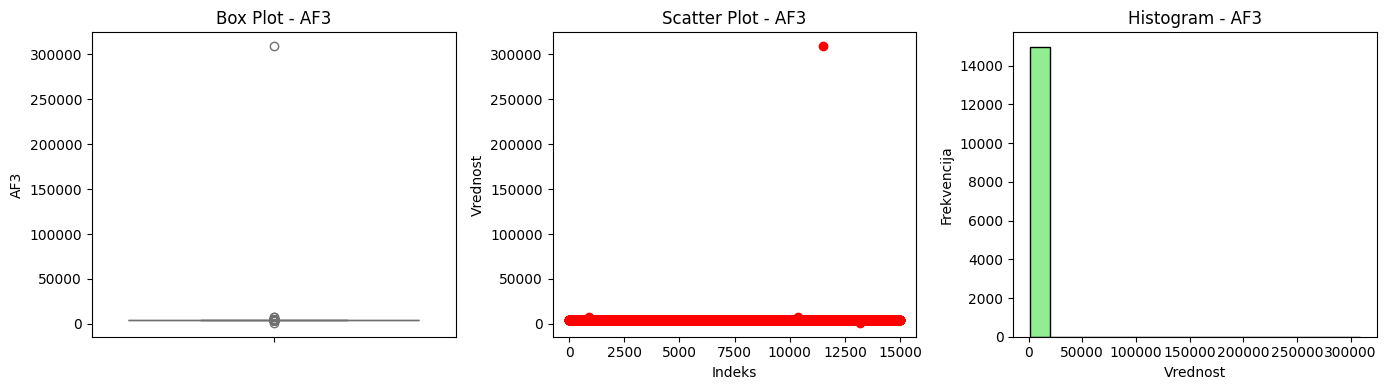

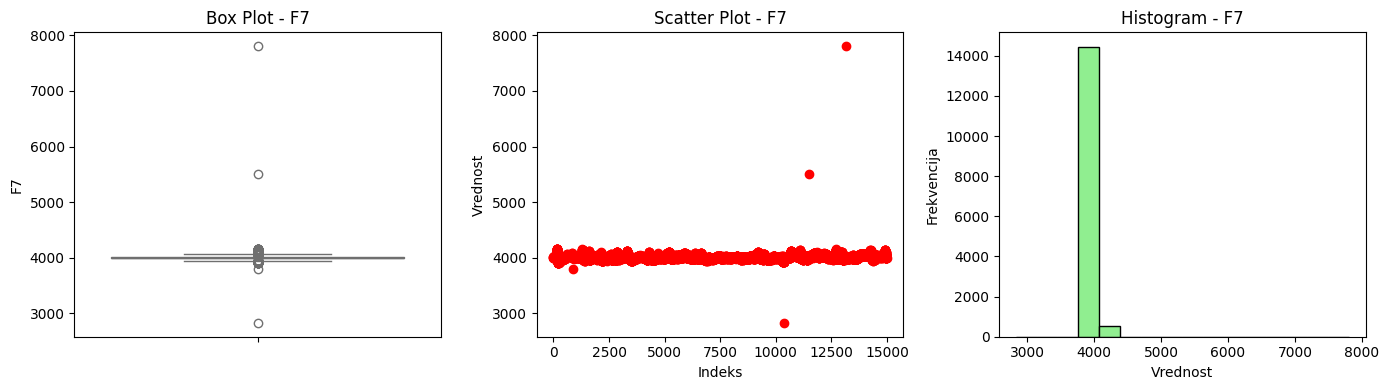

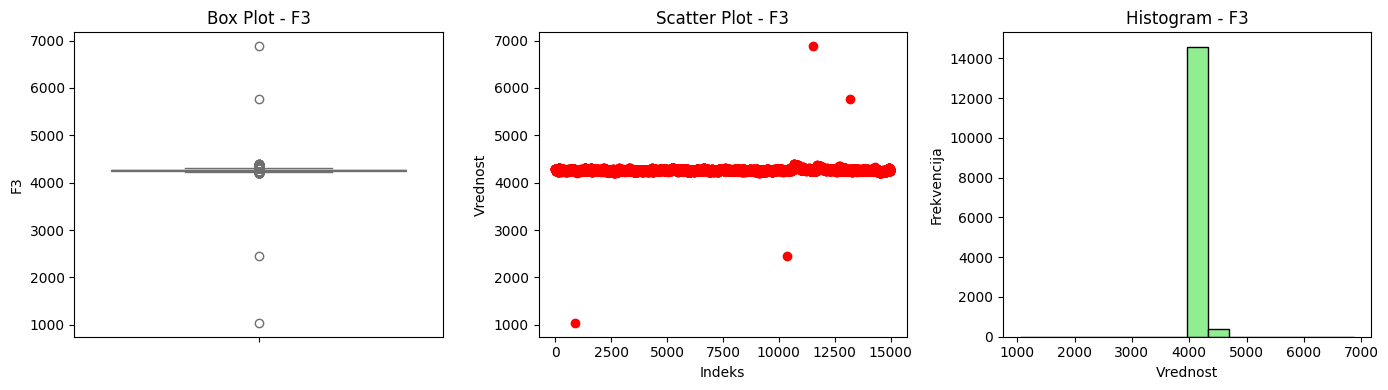

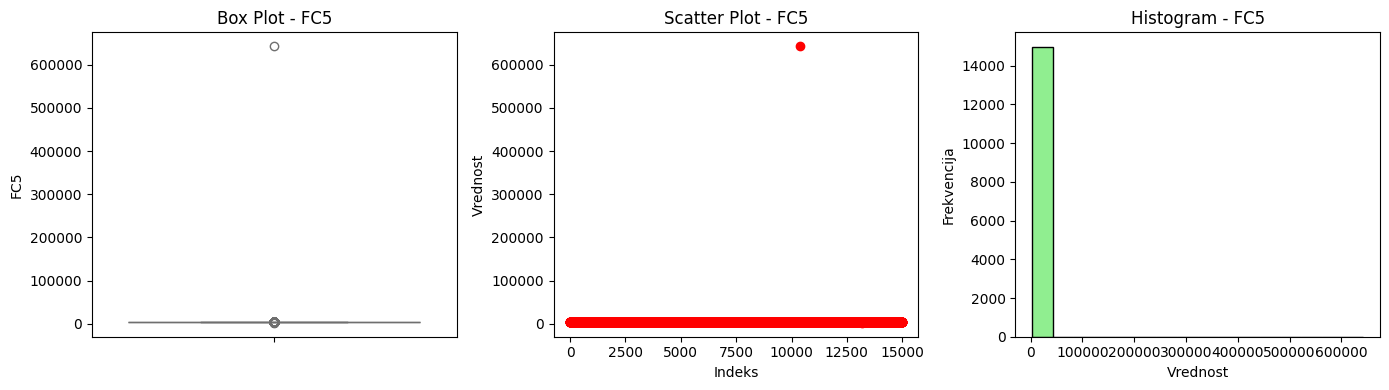

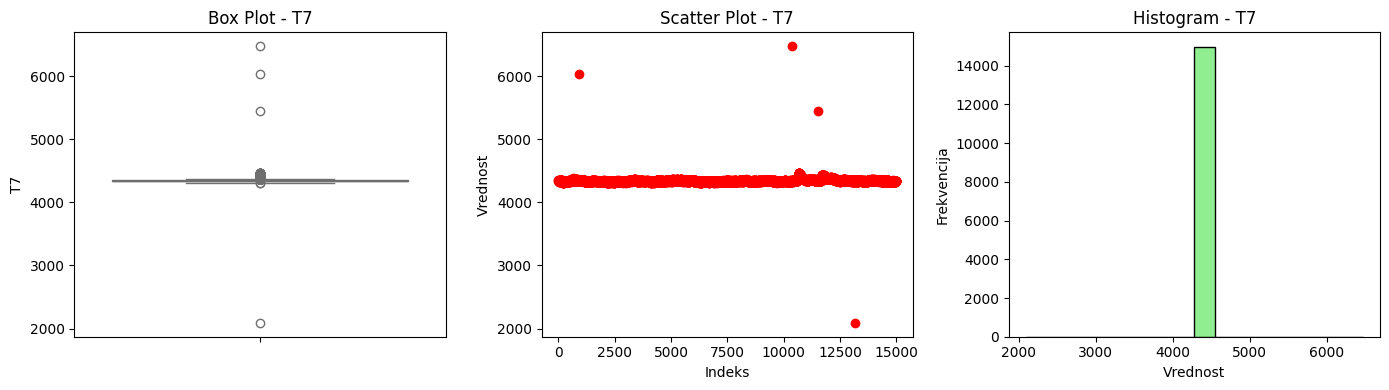

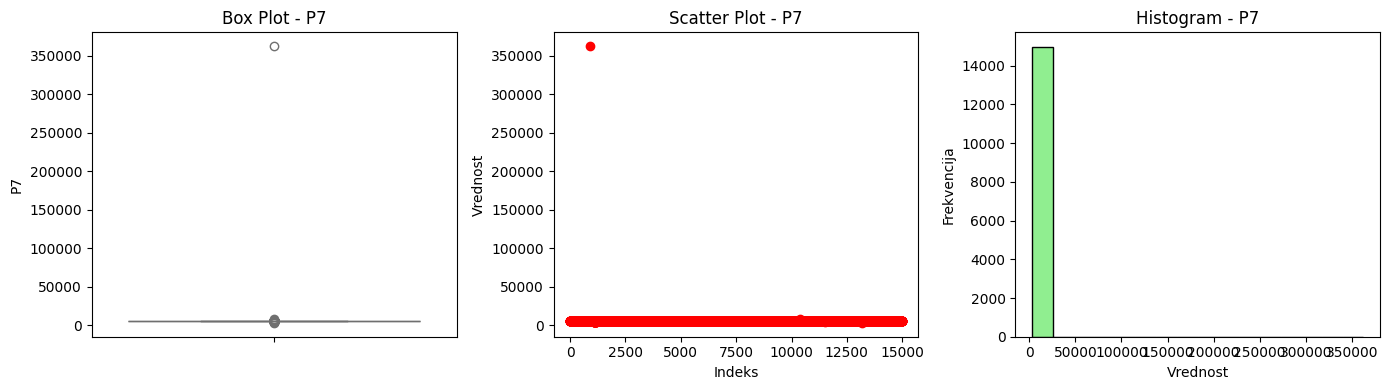

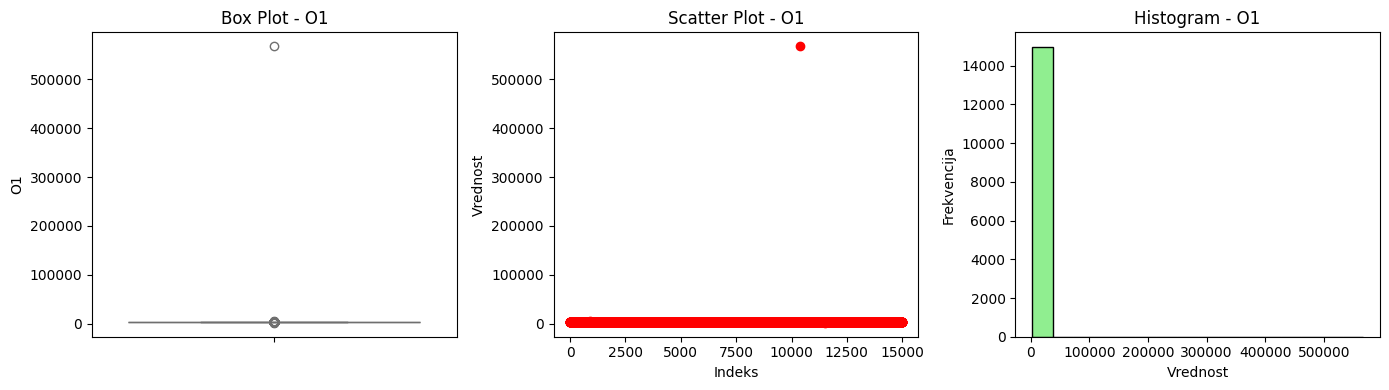

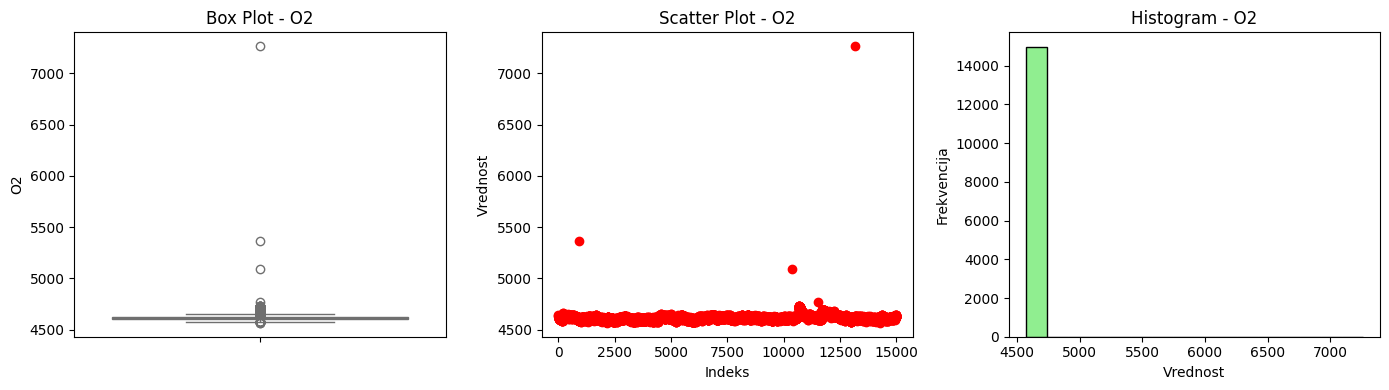

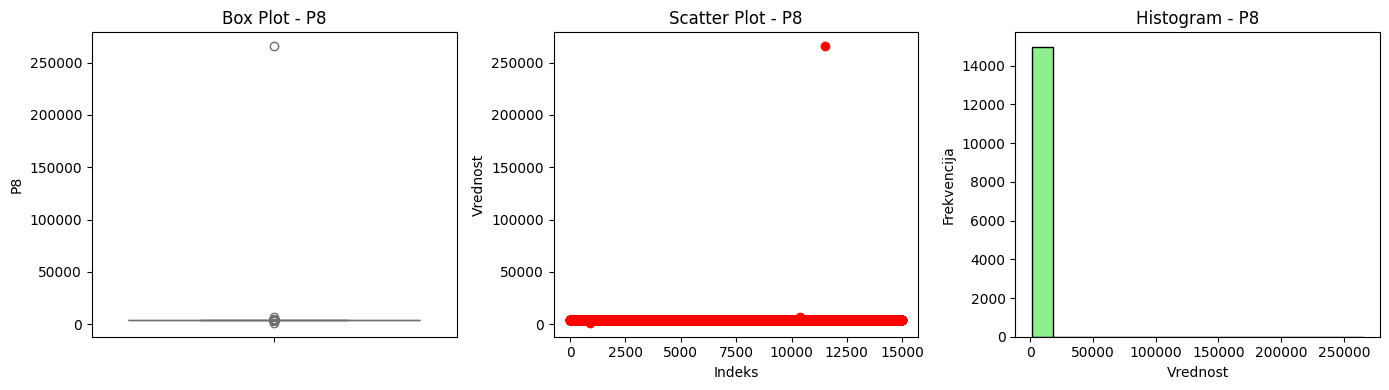

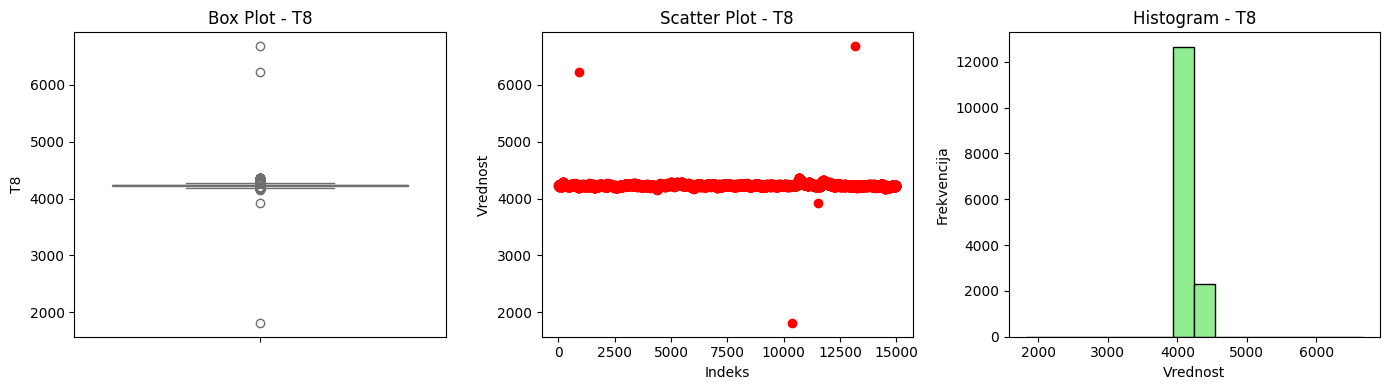

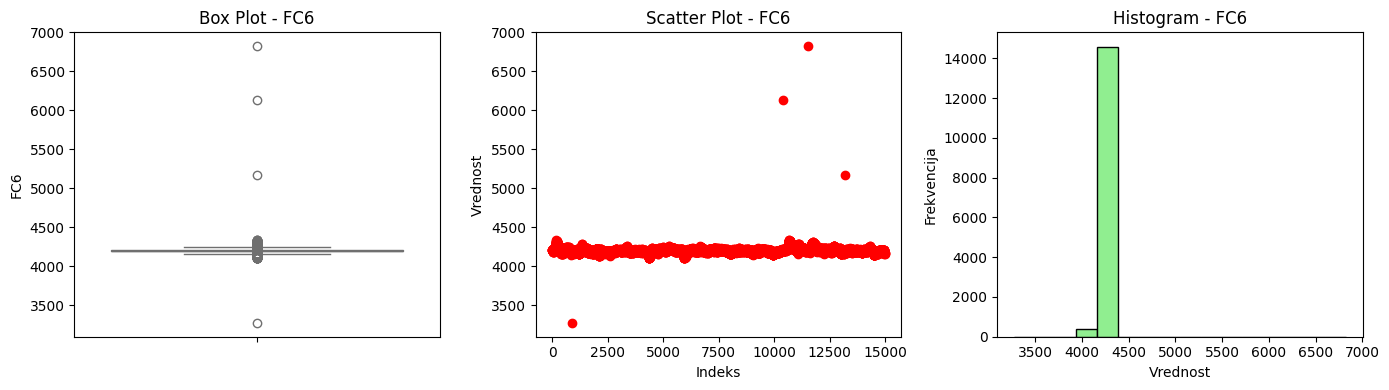

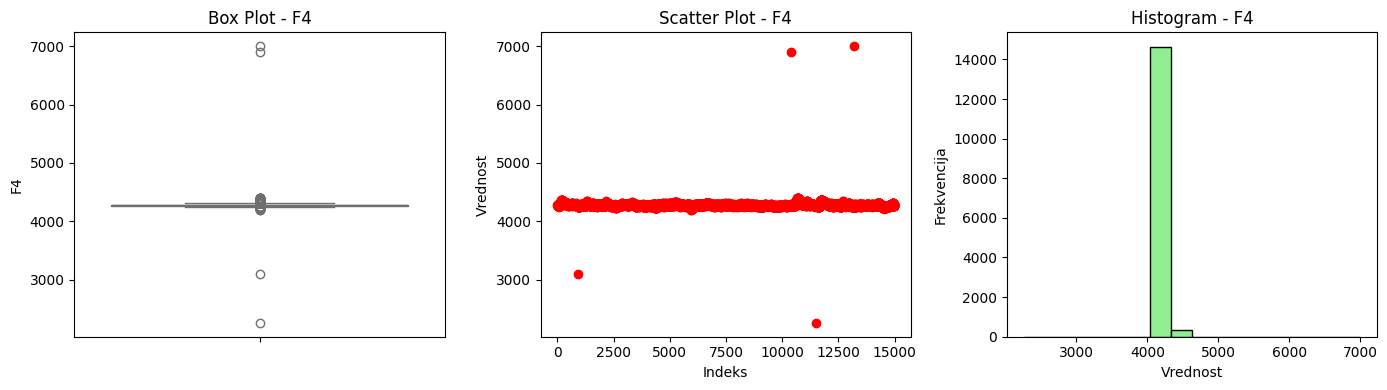

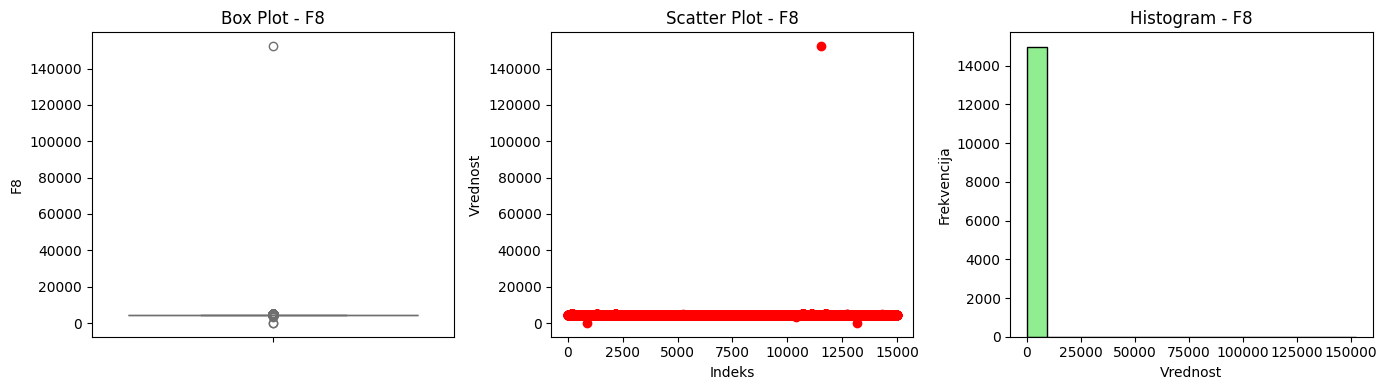

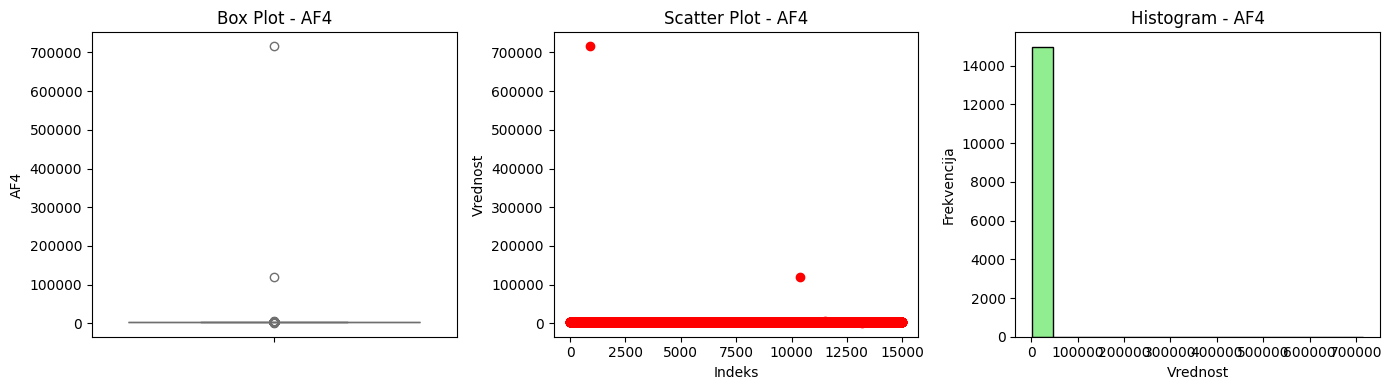

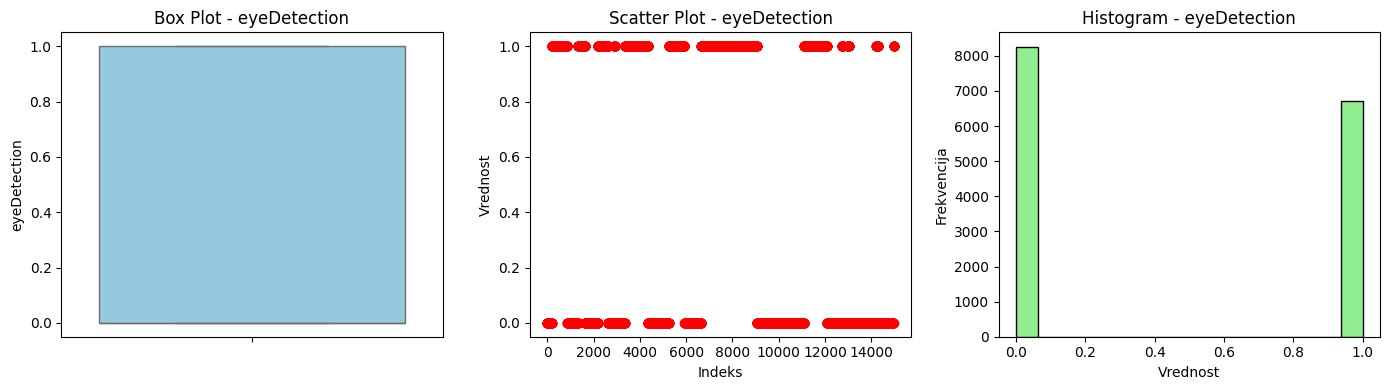

In [36]:
for column in number_columns.columns:
        plt.figure(figsize=(14, 4))
        
        # Box plot
        plt.subplot(1, 3, 1)
        sns.boxplot(y=df[column], color='skyblue')
        plt.title(f"Box Plot - {column}")
        
        # Scatter plot
        plt.subplot(1, 3, 2)
        plt.scatter(x=range(len(df)), y=df[column], color='red')
        plt.title(f"Scatter Plot - {column}")
        plt.xlabel("Indeks")
        plt.ylabel("Vrednost")
        
        # Histogram
        plt.subplot(1, 3, 3)
        plt.hist(df[column], bins=16, color='lightgreen', edgecolor='black')
        plt.title(f"Histogram - {column}")
        plt.xlabel("Vrednost")
        plt.ylabel("Frekvencija")
        
        plt.tight_layout()
        plt.show()

Primena IQR i Z_Score metode za detekciju outlier-a:

In [37]:
for column in number_columns.columns:
        print(f"\n--- Kolona: {column} ---")

        # IQR metoda
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        donja_granica = Q1 - 1.5 * IQR
        gornja_granica = Q3 + 1.5 * IQR
        outlieri_iqr = df[(df[column] < donja_granica) | (df[column] > gornja_granica)]
        print("Outlieri po IQR metodi:")
        print(outlieri_iqr)

        # Z-Score metoda
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        outlieri_zscore = df[(z_scores > 3) | (z_scores < -3)]
        print("Outlieri po Z-Score metodi:")
        print(outlieri_zscore)


--- Kolona: AF3 ---
Outlieri po IQR metodi:
           AF3       F7       F3      FC5       T7       P7       O1       O2  \
152    4375.38  4072.82  4263.08  4150.26  4337.95  4582.56  4056.92  4599.49   
153    4401.54  4090.26  4267.18  4156.41  4336.92  4586.15  4053.33  4598.97   
154    4412.31  4094.36  4262.56  4149.23  4332.31  4591.79  4057.44  4611.28   
155    4416.92  4106.67  4261.03  4153.33  4334.87  4589.23  4062.56  4604.62   
156    4430.26  4123.08  4268.21  4156.92  4336.92  4592.31  4069.74  4592.82   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14935  4397.95  4096.41  4296.92  4155.90  4331.79  4605.13  4063.08  4616.92   
14936  4389.74  4092.82  4287.69  4157.95  4335.38  4607.69  4062.05  4612.82   
14937  4385.13  4089.23  4279.49  4155.90  4334.36  4607.18  4056.92  4614.36   
14938  4374.36  4083.08  4280.00  4155.38  4331.28  4603.08  4053.85  4605.64   
14939  4362.05  4070.26  4280.51  4150.77  4332.31  4599.49  405

U primeru iznad smo detektovali da imamo outlier-e. Sledeći korak je da vidimo koja je najbolja metoda za njihovo otklanjanje. Prvo ćemo da vidimo koliko reodva ima najmanje jedan outliere, ako nije preveliki broj redova možemo ih samo izbrisati.

In [38]:
iqr_mask = pd.Series(False, index=df.index)
zscore_mask = pd.Series(False, index=df.index)

for column in number_columns.columns:
    # IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    donja = Q1 - 1.5 * IQR
    gornja = Q3 + 1.5 * IQR

    iqr_mask |= (df[column] < donja) | (df[column] > gornja)

    # Z-score
    std = df[column].std()
    if std != 0:
        z = (df[column] - df[column].mean()) / std
        zscore_mask |= (z > 3) | (z < -3)

print(f"Broj redova sa bar jednim IQR outlierom: {iqr_mask.sum()}")
print(f"Broj redova sa bar jednim Z-score outlierom: {zscore_mask.sum()}")


Broj redova sa bar jednim IQR outlierom: 3127
Broj redova sa bar jednim Z-score outlierom: 88


Veliki broj redova sadrži bar jedan outlier-e tako da odbacujemo opciju brisanja redova.

## 3. Transformacija podataka

## 4. Treniranje modela

### Podela podataka:

In [39]:
le = LabelEncoder()
y = df['eyeDetection']

X = df.drop(
    ['eyeDetection'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11984, 14)
(2996, 14)
(11984,)
(2996,)


### Lazy Predict

In [40]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(
    verbose=0, 
    ignore_warnings=True, 
    custom_metric=None, 
    predictions=False,
)

models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5388, number of negative: 6596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3546
[LightGBM] [Info] Number of data points in the train set: 11984, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449599 -> initscore=-0.202289
[LightGBM] [Info] Start training from score -0.202289
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.95               0.95     0.95      0.95   
XGBClassifier                      0.94               0.94     0.94      0.94   
LabelPropagation                   0.93               0.93     0.93      0.93   
RandomForestClassifier             0.93

Funkcija za izveštaj o performansama modela:

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def report(y_test, y_pred, title):
    acc = accuracy_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    return {
        "accuracy": acc,
        "classification_report": cr,  # dict forma
        "confusion_matrix": cm
    }
   

### Random Forest

In [42]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler


def run_random_forest_classifier(X_train, y_train, X_test, y_test, preprocessors):
    forest = RandomForestClassifier(random_state=0, n_jobs=1)
    pipe = make_pipeline(*preprocessors, forest)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    res = report(y_test, y_pred, "Random Forest Classifier")
    return res["accuracy"]

print(run_random_forest_classifier(X_train, y_train, X_test, y_test, [StandardScaler()])*100)
print(run_random_forest_classifier(X_train, y_train, X_test, y_test, [MinMaxScaler()])*100)
print(run_random_forest_classifier(X_train, y_train, X_test, y_test, [RobustScaler()])*100)


93.1909212283044
93.25767690253672
93.29105473965286


### Extra Trees Classifier

Radi slično kao Random Forest Classifier, ali u praksi ima veću preciznost. \
n_estimators - broj stabala

In [43]:
from sklearn.ensemble import ExtraTreesClassifier

def run_extra_trees_classifier(X_train, y_train, X_test, y_test, preprocessors):
    et_classifier = ExtraTreesClassifier(n_estimators=100, criterion='gini', random_state=42)

    pipe = make_pipeline(*preprocessors, et_classifier)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Extra Trees Classifier")
    return res["accuracy"]

print(run_extra_trees_classifier(X_train, y_train, X_test, y_test, [StandardScaler()])*100)
print(run_extra_trees_classifier(X_train, y_train, X_test, y_test, [MinMaxScaler()])*100)
print(run_extra_trees_classifier(X_train, y_train, X_test, y_test, [RobustScaler()])*100)

    # print("\nFeature Importances:")
    # features_and_scores = zip(X.columns, et_classifier.feature_importances_)
    # sorted_features = sorted(features_and_scores, key=lambda x: x[1], reverse=True)

    # for feature, importance in sorted_features:
    #     print(f"{feature}: {importance:.4f}")
        

95.16021361815754
95.22696929238985
95.16021361815754


### K-Nearest Neighbours (KNN)

Lazy predictor \
K - broj najbiližih tačaka koje su uzimaju u obzir

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

def run_knn_classifier(X_train, y_train, X_test, y_test, preprocessors):
    # pipe = Pipeline([
    #     ("preprocessor", *preprocessors),
    #     ("knn", KNeighborsClassifier())
    # ])
    pipe = make_pipeline(*preprocessors, KNeighborsClassifier())


    k_values = range(1, 300, 2) 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    best_k, best_score = None, -1
    for k in k_values:
        pipe.set_params(kneighborsclassifier__n_neighbors=k)
        scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    # print(f"Najbolji K: {best_k}, CV accuracy: {best_score:.4f}")

    pipe.set_params(kneighborsclassifier__n_neighbors=best_k)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "K-Nearest Neighbour Classifier")
    return res["accuracy"]
print(run_knn_classifier(X_train, y_train, X_test, y_test, [StandardScaler()])*100)
print(run_knn_classifier(X_train, y_train, X_test, y_test, [MinMaxScaler()])*100)
print(run_knn_classifier(X_train, y_train, X_test, y_test, [RobustScaler()])*100)


92.02269692923899
91.85580774365822
97.09612817089453


### SVM

In [45]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def run_svm_classifier(X_train, y_train, X_test, y_test, preprocessors):
    pipe = make_pipeline(*preprocessors, SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0))
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "SVM Classifier")
    return res["accuracy"]
print(run_svm_classifier(X_train, y_train, X_test, y_test, [StandardScaler()])*100)
print(run_svm_classifier(X_train, y_train, X_test, y_test, [MinMaxScaler()])*100)
print(run_svm_classifier(X_train, y_train, X_test, y_test, [RobustScaler()])*100)

72.53004005340455
55.44058744993324
55.44058744993324


### Logisticka regresija



Pogodna je za binarnu klasifikaciju.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

def run_logistic_regression_classifier(X_train, y_train, X_test, y_test, preprocessors):
    clf = LogisticRegression(
        max_iter=100,
        solver="lbfgs",    
        n_jobs = 1
    )

    pipe = make_pipeline(*preprocessors, clf)

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Logistic Regression Classifier")
    return res["accuracy"]
print(run_logistic_regression_classifier(X_train, y_train, X_test, y_test, [StandardScaler()])*100)
print(run_logistic_regression_classifier(X_train, y_train, X_test, y_test, [MinMaxScaler()])*100)
print(run_logistic_regression_classifier(X_train, y_train, X_test, y_test, [RobustScaler()])*100)
    

59.17890520694259
55.80774365821095
63.81842456608812


### Naive Bayes

Naivna metoda - algoritam smatra da je svaki fature nekorelisan.

In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold

def run_naive_bayes_classifier(X_train, y_train, X_test, y_test, preprocessors):
    pipe = make_pipeline(*preprocessors, GaussianNB())
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Naive Bayes Classifier")
    return res["accuracy"]
print(run_naive_bayes_classifier(X_train, y_train, X_test, y_test, [StandardScaler()])*100)
print(run_naive_bayes_classifier(X_train, y_train, X_test, y_test, [MinMaxScaler()])*100)
print(run_naive_bayes_classifier(X_train, y_train, X_test, y_test, [RobustScaler()])*100)

49.365821094793056
49.365821094793056
49.365821094793056


### Decision Tree Classifier

Kreiranje stabla odlučivanja na osnovu feature-a

In [48]:
from sklearn.tree import DecisionTreeClassifier

def run_decision_tree_classifier(X_train, y_train, X_test, y_test, preprocessors):
    clf = DecisionTreeClassifier(random_state=0)

    pipe = make_pipeline(*preprocessors, clf)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = report(y_test, y_pred, "Decision Tree Classifier")
    return res["accuracy"]
print(run_decision_tree_classifier(X_train, y_train, X_test, y_test, [StandardScaler()])*100)
print(run_decision_tree_classifier(X_train, y_train, X_test, y_test, [MinMaxScaler()])*100)
print(run_decision_tree_classifier(X_train, y_train, X_test, y_test, [RobustScaler()])*100)
    

84.47930574098798
84.5460614152203
84.57943925233646


In [49]:
# def run_classifiers(X_train, y_train, X_test, y_test, prepocessors):
#     run_random_forest_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_extra_trees_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_knn_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_svm_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_logistic_regression_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_naive_bayes_classifier(X_train, y_train, X_test, y_test, prepocessors)
#     run_decision_tree_classifier(X_train, y_train, X_test, y_test, prepocessors)

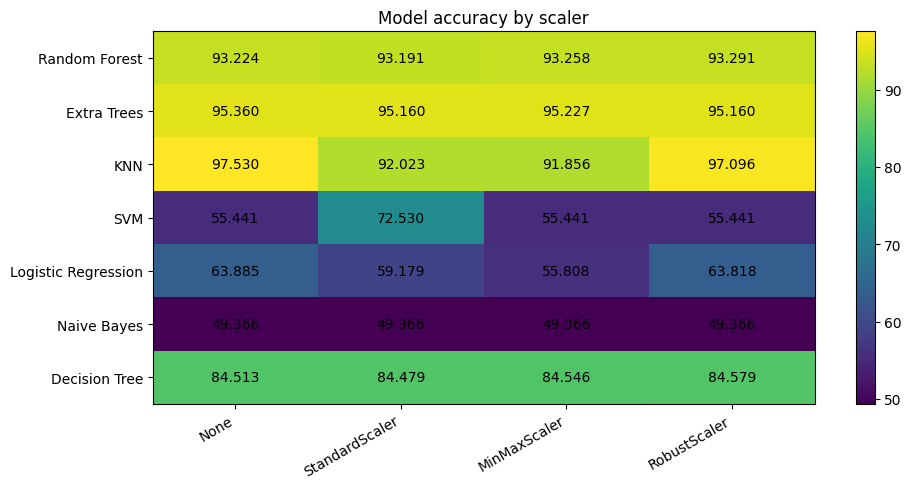

In [50]:


def run_classifiers_matrix(X_train, y_train, X_test, y_test, scalers_dict):
    algorithms = {
        "Random Forest": run_random_forest_classifier,
        "Extra Trees": run_extra_trees_classifier,
        "KNN": run_knn_classifier,
        "SVM": run_svm_classifier,
        "Logistic Regression": run_logistic_regression_classifier,
        "Naive Bayes": run_naive_bayes_classifier,
        "Decision Tree": run_decision_tree_classifier,
    }

    matrix = pd.DataFrame(index=algorithms.keys(), columns=scalers_dict.keys(), dtype=float)

    for algo_name, algo_fn in algorithms.items():
        for scaler_name, preprocessors in scalers_dict.items():
            acc = algo_fn(X_train, y_train, X_test, y_test, preprocessors) * 100
            matrix.loc[algo_name, scaler_name] = acc

    return matrix

def plot_matrix_heatmap(df, title="Accuracy matrix"):
    data = df.values.astype(float)

    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(data, aspect="auto") 

    ax.set_title(title)
    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(df.columns, rotation=30, ha="right")
    ax.set_yticklabels(df.index)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            val = data[i, j]
            txt = "NA" if np.isnan(val) else f"{val:.3f}"
            ax.text(j, i, txt, ha="center", va="center")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()
    
scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],
    "RobustScaler": [RobustScaler()],
}

acc_matrix = run_classifiers_matrix(X_train, y_train, X_test, y_test, scalers)
plot_matrix_heatmap(acc_matrix, title="Model accuracy by scaler")


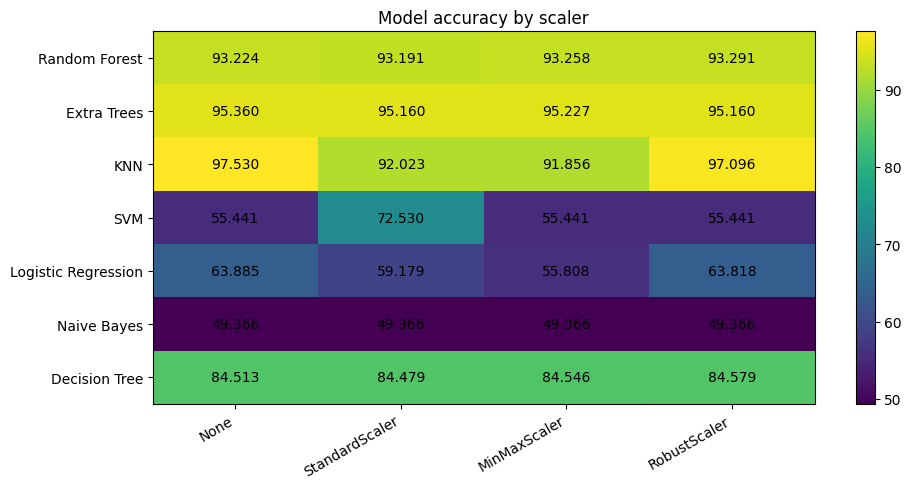

In [ ]:
df_no_outliers = df[~zscore_mask]

le = LabelEncoder()
y = df_no_outliers['eyeDetection']

X = df_no_outliers.drop(
    ['eyeDetection'],
    axis=1
)

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X, y, test_size=0.2, random_state=1
)

scalers = {
    "None": [],
    "StandardScaler": [StandardScaler()],
    "MinMaxScaler": [MinMaxScaler()],
    "RobustScaler": [RobustScaler()],
}

acc_matrix = run_classifiers_matrix(X_train_no_outliers, y_train_no_outliers, X_test_no_outliers, y_test_no_outliers, scalers)
plot_matrix_heatmap(acc_matrix, title="Model accuracy by scaler")


## 5. Sistematska analiza: Baseline → Optimizovani modeli

U ovom delu ćemo sistematski pokazati uticaj svakog koraka obrade podataka na performanse modela:
1. **Baseline** - sirovi podaci bez ikakve obrade
2. **Korak 1** - Standardizacija podataka (StandardScaler)
3. **Korak 2** - Uklanjanje visoko korelisanih feature-a
4. **Korak 3** - Redukcija dimenzionalnosti (PCA)
5. **Korak 4** - Optimizacija hiperparametara
6. **Korak 5** - Analiza interpretabilnosti (Feature Importance, SHAP, LIME)

In [1]:
# Instalacija potrebnih biblioteka za interpretabilnost
import warnings
warnings.filterwarnings('ignore')

# Reimport za čist početak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Učitavanje podataka
df = pd.read_csv("input-eeg.csv")
df = df.drop_duplicates()

print(f"Ukupno redova: {len(df)}")
print(f"Ukupno kolona: {len(df.columns)}")
print(f"Distribucija klasa:\n{df['eyeDetection'].value_counts()}")

Ukupno redova: 14980
Ukupno kolona: 15
Distribucija klasa:
eyeDetection
0    8257
1    6723
Name: count, dtype: int64


### 5.1 Definicija funkcija za evaluaciju

In [2]:
def evaluate_all_models(X_train, X_test, y_train, y_test, step_name=""):
    """
    Evaluacija svih klasifikatora i vraćanje rezultata u DataFrame formatu.
    """
    models = {
        "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
        "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "SVM": SVC(kernel='rbf', random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
    }
    
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results.append({
            "Model": name,
            "Accuracy (%)": round(acc * 100, 2),
            "F1-Score (%)": round(f1 * 100, 2),
            "Step": step_name
        })
    
    return pd.DataFrame(results)

def plot_comparison(results_df, title="Poređenje modela"):
    """Vizualizacija rezultata modela."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(results_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df['Accuracy (%)'], width, label='Accuracy', color='steelblue')
    bars2 = ax.bar(x + width/2, results_df['F1-Score (%)'], width, label='F1-Score', color='coral')
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Score (%)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 100)
    
    # Dodavanje vrednosti na barove
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

print("Funkcije za evaluaciju definisane.")

Funkcije za evaluaciju definisane.


### 5.2 BASELINE - Sirovi podaci bez obrade

Prvo testiramo sve modele na sirovim podacima bez ikakve normalizacije ili skaliranja.

BASELINE REZULTATI - Sirovi podaci bez obrade
              Model  Accuracy (%)  F1-Score (%)     Step
      Random Forest         92.96         92.94 Baseline
        Extra Trees         94.59         94.58 Baseline
                KNN         96.83         96.83 Baseline
                SVM         55.11         39.16 Baseline
Logistic Regression         63.45         62.59 Baseline
        Naive Bayes         45.59         31.72 Baseline
      Decision Tree         82.64         82.65 Baseline


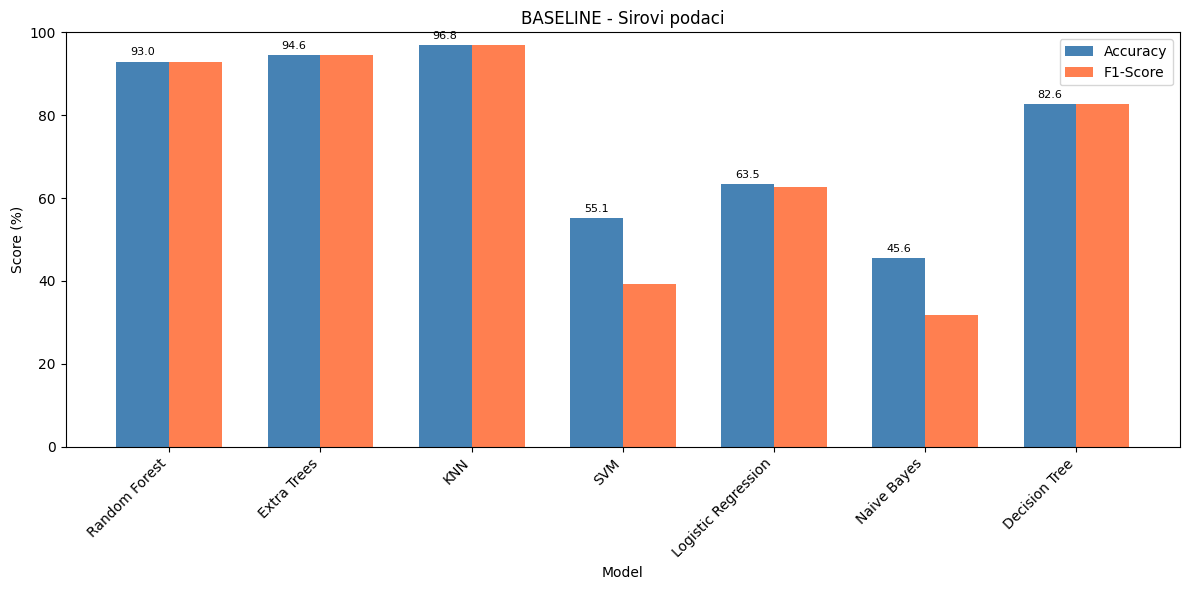

In [3]:
# Priprema podataka - BASELINE (sirovi podaci)
X = df.drop(['eyeDetection'], axis=1)
y = df['eyeDetection']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("=" * 60)
print("BASELINE REZULTATI - Sirovi podaci bez obrade")
print("=" * 60)

baseline_results = evaluate_all_models(X_train, X_test, y_train, y_test, "Baseline")
print(baseline_results.to_string(index=False))
plot_comparison(baseline_results, "BASELINE - Sirovi podaci")

# Čuvamo rezultate za poređenje
all_results = [baseline_results.copy()]

### 5.3 KORAK 1 - Standardizacija podataka (StandardScaler)

Primenjujemo StandardScaler koji normalizuje podatke tako da imaju srednju vrednost 0 i standardnu devijaciju 1.

KORAK 1 - Standardizacija podataka (StandardScaler)
              Model  Accuracy (%)  F1-Score (%)            Step
      Random Forest         92.89         92.87 Standardizacija
        Extra Trees         94.49         94.48 Standardizacija
                KNN         91.02         91.00 Standardizacija
                SVM         69.39         66.71 Standardizacija
Logistic Regression         58.51         56.76 Standardizacija
        Naive Bayes         45.59         31.72 Standardizacija
      Decision Tree         82.74         82.75 Standardizacija


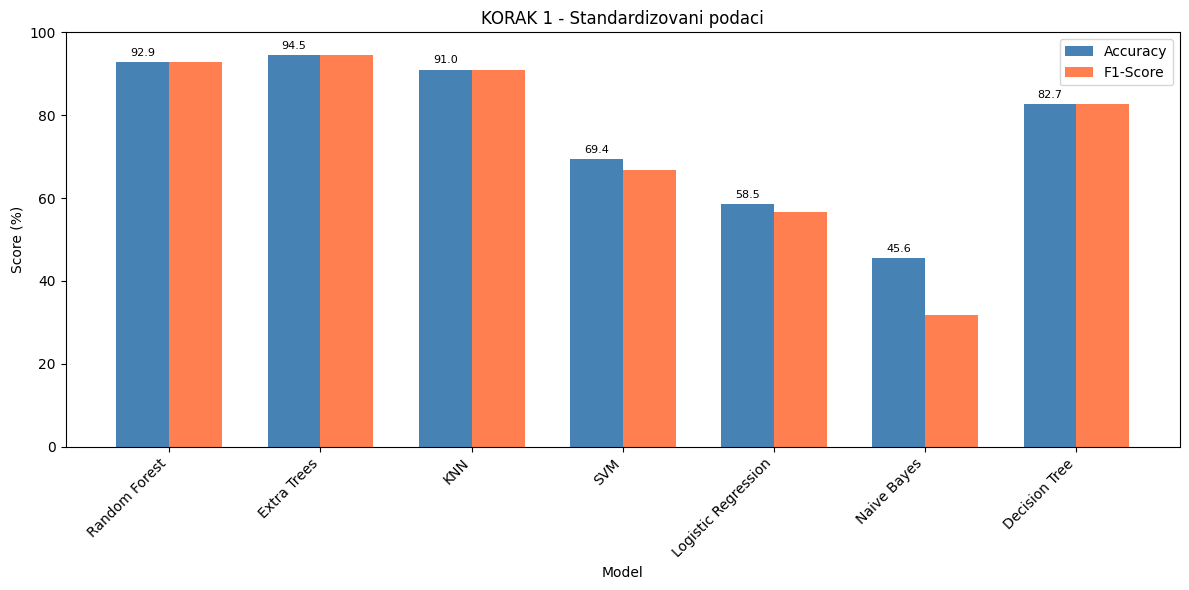

In [4]:
# KORAK 1 - Standardizacija podataka
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=" * 60)
print("KORAK 1 - Standardizacija podataka (StandardScaler)")
print("=" * 60)

step1_results = evaluate_all_models(X_train_scaled, X_test_scaled, y_train, y_test, "Standardizacija")
print(step1_results.to_string(index=False))
plot_comparison(step1_results, "KORAK 1 - Standardizovani podaci")

all_results.append(step1_results.copy())

### 5.4 KORAK 2 - Uklanjanje visoko korelisanih feature-a

Na osnovu ranije analize korelacije, uklanjamo redundantne feature-e koji imaju korelaciju > 0.95.

Uklonjene kolone (korelacija > 0.95): ['O1', 'P8', 'F8', 'AF4']
Preostalo feature-a: 10

KORAK 2 - Uklanjanje visoko korelisanih feature-a
              Model  Accuracy (%)  F1-Score (%)           Step
      Random Forest         88.05         88.01 Bez korelacija
        Extra Trees         90.39         90.35 Bez korelacija
                KNN         87.58         87.58 Bez korelacija
                SVM         68.96         66.57 Bez korelacija
Logistic Regression         58.31         56.53 Bez korelacija
        Naive Bayes         45.96         32.74 Bez korelacija
      Decision Tree         78.87         78.87 Bez korelacija


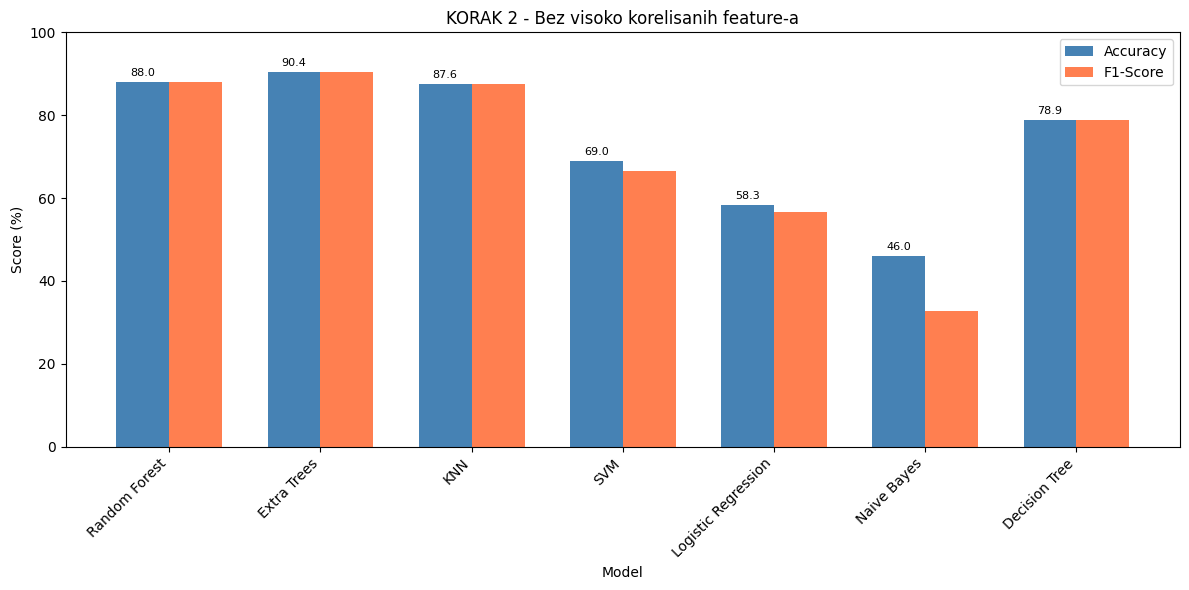

In [5]:
# KORAK 2 - Uklanjanje visoko korelisanih feature-a
def remove_highly_correlated(df, threshold=0.95):
    """Uklanja feature-e sa korelacijom većom od threshold."""
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

X_reduced, dropped_cols = remove_highly_correlated(X, threshold=0.95)
print(f"Uklonjene kolone (korelacija > 0.95): {dropped_cols}")
print(f"Preostalo feature-a: {X_reduced.shape[1]}")

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

scaler2 = StandardScaler()
X_train_reduced_scaled = scaler2.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler2.transform(X_test_reduced)

print("\n" + "=" * 60)
print("KORAK 2 - Uklanjanje visoko korelisanih feature-a")
print("=" * 60)

step2_results = evaluate_all_models(X_train_reduced_scaled, X_test_reduced_scaled, y_train, y_test, "Bez korelacija")
print(step2_results.to_string(index=False))
plot_comparison(step2_results, "KORAK 2 - Bez visoko korelisanih feature-a")

all_results.append(step2_results.copy())

### 5.5 KORAK 3 - Redukcija dimenzionalnosti (PCA)

Primenjujemo PCA (Principal Component Analysis) za redukciju dimenzionalnosti sa zadržavanjem 95% varijanse.

PCA analiza - različiti brojevi komponenti:
 n_components  explained_variance  accuracy
            5           96.257320 74.365821
            7           98.846971 80.373832
           10           99.793332 88.017356
           12           99.999928 90.420561


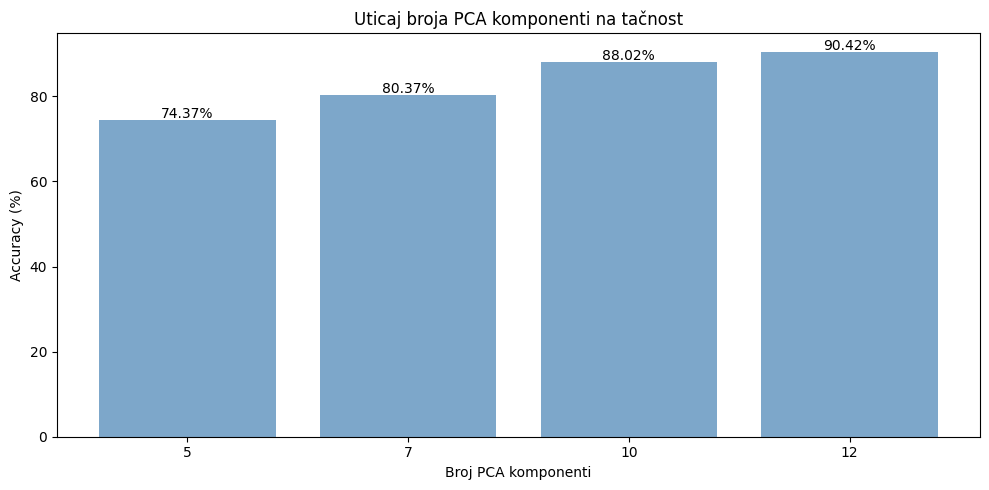

In [6]:
# KORAK 3 - PCA redukcija dimenzionalnosti
# Testiramo različite broj komponenti
pca_results = []

for n_components in [5, 7, 10, 12]:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    explained_var = sum(pca.explained_variance_ratio_) * 100
    
    # Testiramo najbolji model do sada (Extra Trees)
    et = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    et.fit(X_train_pca, y_train)
    acc = accuracy_score(y_test, et.predict(X_test_pca))
    
    pca_results.append({
        "n_components": n_components,
        "explained_variance": explained_var,
        "accuracy": acc * 100
    })

pca_df = pd.DataFrame(pca_results)
print("PCA analiza - različiti brojevi komponenti:")
print(pca_df.to_string(index=False))

# Vizualizacija
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(pca_df['n_components'].astype(str), pca_df['accuracy'], color='steelblue', alpha=0.7)
ax.set_xlabel('Broj PCA komponenti')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Uticaj broja PCA komponenti na tačnost')
for i, v in enumerate(pca_df['accuracy']):
    ax.text(i, v + 0.5, f'{v:.2f}%', ha='center')
plt.tight_layout()
plt.show()

Optimalni broj komponenti za 95% varijanse: 5
Objašnjena varijansa: 96.26%

KORAK 3 - PCA redukcija dimenzionalnosti
              Model  Accuracy (%)  F1-Score (%) Step
      Random Forest         73.23         73.08  PCA
        Extra Trees         74.37         74.08  PCA
                KNN         73.80         73.68  PCA
                SVM         61.32         53.83  PCA
Logistic Regression         56.04         53.10  PCA
        Naive Bayes         47.16         36.38  PCA
      Decision Tree         65.25         65.27  PCA


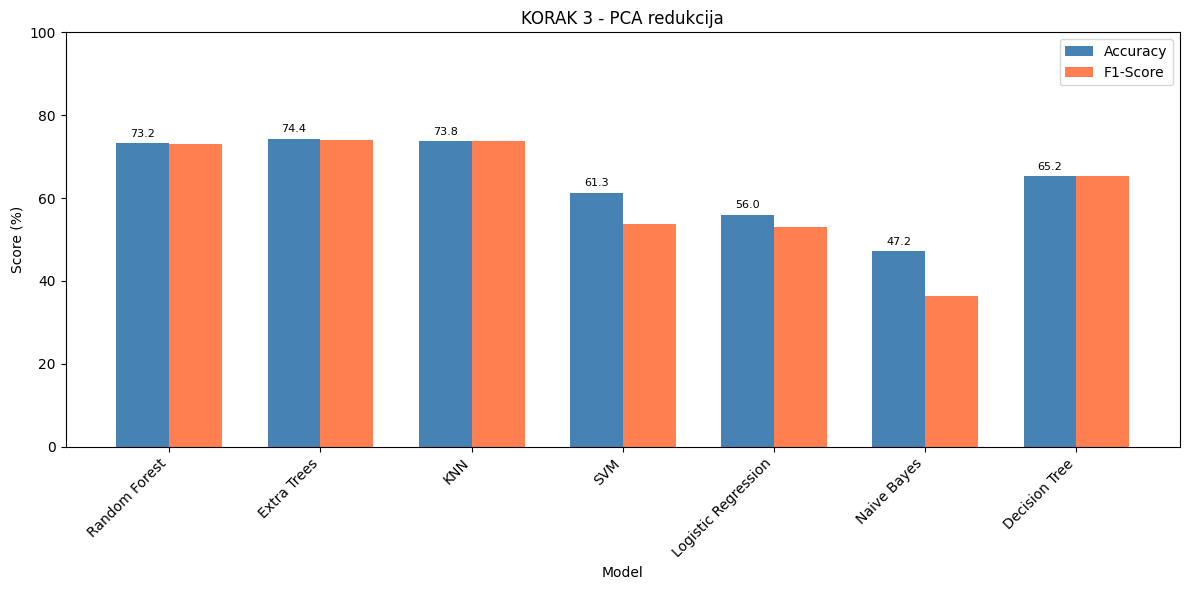

In [7]:
# Primena optimalnog PCA (zadržavamo 95% varijanse)
pca_optimal = PCA(n_components=0.95)
X_train_pca_opt = pca_optimal.fit_transform(X_train_scaled)
X_test_pca_opt = pca_optimal.transform(X_test_scaled)

print(f"Optimalni broj komponenti za 95% varijanse: {pca_optimal.n_components_}")
print(f"Objašnjena varijansa: {sum(pca_optimal.explained_variance_ratio_)*100:.2f}%")

print("\n" + "=" * 60)
print("KORAK 3 - PCA redukcija dimenzionalnosti")
print("=" * 60)

step3_results = evaluate_all_models(X_train_pca_opt, X_test_pca_opt, y_train, y_test, "PCA")
print(step3_results.to_string(index=False))
plot_comparison(step3_results, "KORAK 3 - PCA redukcija")

all_results.append(step3_results.copy())

### 5.6 KORAK 4 - Optimizacija hiperparametara

Koristimo GridSearchCV i RandomizedSearchCV za optimizaciju hiperparametara najboljih modela.

In [8]:
# KORAK 4 - Optimizacija hiperparametara
print("=" * 60)
print("KORAK 4 - Optimizacija hiperparametara")
print("=" * 60)

# Random Forest optimizacija
print("\n--- Random Forest optimizacija ---")
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = RandomizedSearchCV(rf, rf_param_grid, n_iter=20, cv=5, scoring='accuracy', 
                              random_state=42, n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)

print(f"Najbolji parametri: {rf_grid.best_params_}")
print(f"Najbolja CV tačnost: {rf_grid.best_score_*100:.2f}%")

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)
print(f"Test tačnost: {accuracy_score(y_test, rf_pred)*100:.2f}%")

KORAK 4 - Optimizacija hiperparametara

--- Random Forest optimizacija ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3Zhci9mb2xkZXJzL3ZoLzFkOTVfX3B4MnJuZzd5MXFzd256a3BkYzAwMDBnbi9UL2pvYmxpYl9tZW1tYXBwaW5nX2ZvbGRlcl8xODMyMl80ZGFjNjU0YmVkNjI0ZjMyYmQ5MDgyZTVlMmNiN2FlNV80MTNkMGYzYTlhM2U0ZDJiOGNhZjM3YjJkZTYwZGNmMw=="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"semlock","base64_name" for automatic

Najbolji parametri: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Najbolja CV tačnost: 92.47%
Test tačnost: 93.22%


In [9]:
# Extra Trees optimizacija
print("\n--- Extra Trees optimizacija ---")
et_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

et = ExtraTreesClassifier(random_state=42, n_jobs=-1)
et_grid = RandomizedSearchCV(et, et_param_grid, n_iter=20, cv=5, scoring='accuracy', 
                              random_state=42, n_jobs=-1, verbose=1)
et_grid.fit(X_train_scaled, y_train)

print(f"Najbolji parametri: {et_grid.best_params_}")
print(f"Najbolja CV tačnost: {et_grid.best_score_*100:.2f}%")

et_best = et_grid.best_estimator_
et_pred = et_best.predict(X_test_scaled)
print(f"Test tačnost: {accuracy_score(y_test, et_pred)*100:.2f}%")


--- Extra Trees optimizacija ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3Zhci9mb2xkZXJzL3ZoLzFkOTVfX3B4MnJuZzd5MXFzd256a3BkYzAwMDBnbi9UL2pvYmxpYl9tZW1tYXBwaW5nX2ZvbGRlcl8xODMyMl85NWMyY2UxYzUyZTI0NjZiYmYxNzQ2NjZlMmFmZmM3M19kMzVlYjFlYTM1NmQ0ZWViYTNjYWUxNDQ5ZDFjZDg0Mw=="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic 

Najbolji parametri: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Najbolja CV tačnost: 94.33%
Test tačnost: 94.86%


In [10]:
# KNN optimizacija
print("\n--- KNN optimizacija ---")
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 11, 15, 21, 31],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
knn_grid.fit(X_train_scaled, y_train)

print(f"Najbolji parametri: {knn_grid.best_params_}")
print(f"Najbolja CV tačnost: {knn_grid.best_score_*100:.2f}%")

knn_best = knn_grid.best_estimator_
knn_pred = knn_best.predict(X_test_scaled)
print(f"Test tačnost: {accuracy_score(y_test, knn_pred)*100:.2f}%")


--- KNN optimizacija ---
Fitting 5 folds for each of 42 candidates, totalling 210 fits


Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3Zhci9mb2xkZXJzL3ZoLzFkOTVfX3B4MnJuZzd5MXFzd256a3BkYzAwMDBnbi9UL2pvYmxpYl9tZW1tYXBwaW5nX2ZvbGRlcl8xODMyMl81MDYwMjNkNDU2OTQ0ZjM2YWMxZWU3NzkyMTJhODYyZl8yZWNiZTkwMjU5OTY0MGVkOGExZWI0MDZkMzhmYTU3Mg=="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic 

Najbolji parametri: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Najbolja CV tačnost: 89.59%
Test tačnost: 91.22%


In [11]:
# SVM optimizacija
print("\n--- SVM optimizacija ---")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

svm = SVC(random_state=42)
svm_grid = RandomizedSearchCV(svm, svm_param_grid, n_iter=15, cv=5, scoring='accuracy', 
                               random_state=42, n_jobs=-1, verbose=1)
svm_grid.fit(X_train_scaled, y_train)

print(f"Najbolji parametri: {svm_grid.best_params_}")
print(f"Najbolja CV tačnost: {svm_grid.best_score_*100:.2f}%")

svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test_scaled)
print(f"Test tačnost: {accuracy_score(y_test, svm_pred)*100:.2f}%")


--- SVM optimizacija ---
Fitting 5 folds for each of 15 candidates, totalling 75 fits


Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3Zhci9mb2xkZXJzL3ZoLzFkOTVfX3B4MnJuZzd5MXFzd256a3BkYzAwMDBnbi9UL2pvYmxpYl9tZW1tYXBwaW5nX2ZvbGRlcl8xODMyMl82ODE0MzRlYjVhZjE0N2M2YmU1MTgzZmViNzA2NzM1Y19jNWQ1YzVjN2UxOTM0MWI1OGI3YWJiZDY1YTg1NmM3Nw=="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic 

Najbolji parametri: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
Najbolja CV tačnost: 82.09%
Test tačnost: 83.44%



Rezultati nakon optimizacije hiperparametara
              Model  Accuracy (%)  F1-Score (%)         Step
Random Forest (opt)         93.22         93.21 Optimizovano
  Extra Trees (opt)         94.86         94.85 Optimizovano
          KNN (opt)         91.22         91.21 Optimizovano
          SVM (opt)         83.44         83.27 Optimizovano


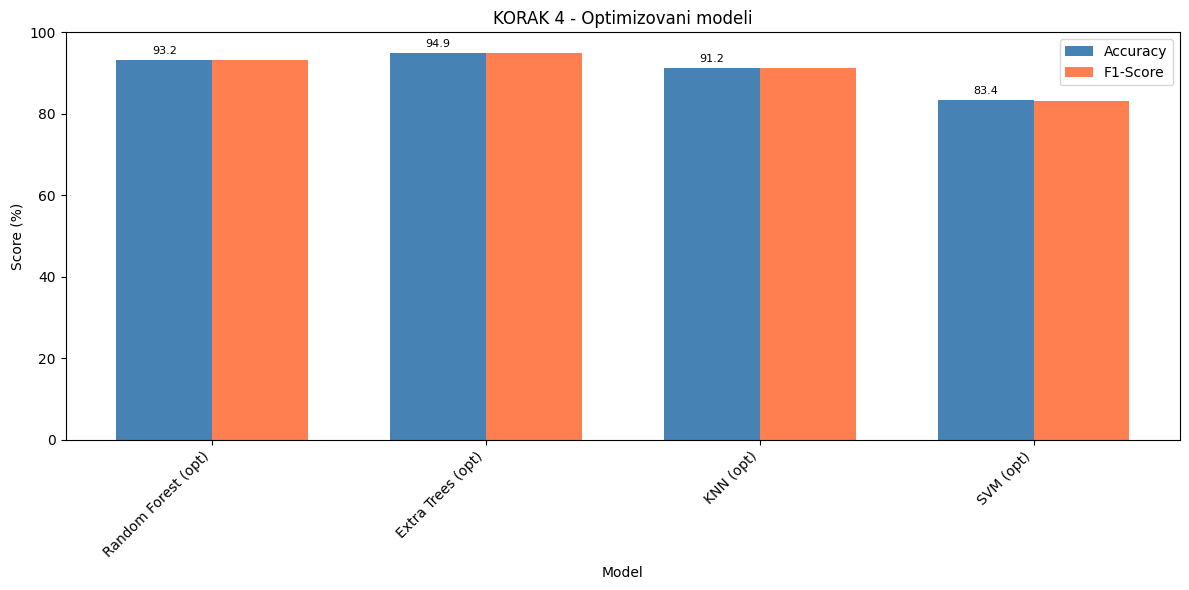

In [12]:
# Sumarni rezultati nakon optimizacije hiperparametara
print("\n" + "=" * 60)
print("Rezultati nakon optimizacije hiperparametara")
print("=" * 60)

optimized_results = pd.DataFrame([
    {"Model": "Random Forest (opt)", "Accuracy (%)": round(accuracy_score(y_test, rf_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test, rf_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "Extra Trees (opt)", "Accuracy (%)": round(accuracy_score(y_test, et_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test, et_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "KNN (opt)", "Accuracy (%)": round(accuracy_score(y_test, knn_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test, knn_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
    {"Model": "SVM (opt)", "Accuracy (%)": round(accuracy_score(y_test, svm_pred)*100, 2), 
     "F1-Score (%)": round(f1_score(y_test, svm_pred, average='weighted')*100, 2), "Step": "Optimizovano"},
])

print(optimized_results.to_string(index=False))
plot_comparison(optimized_results, "KORAK 4 - Optimizovani modeli")

all_results.append(optimized_results.copy())

## 6. Analiza interpretabilnosti modela

U ovom delu analiziramo interpretabilnost modela koristeći:
- **Feature Importance** - značaj feature-a u tree-based modelima
- **SHAP vrednosti** - SHapley Additive exPlanations
- **LIME** - Local Interpretable Model-agnostic Explanations

### 6.1 Feature Importance (Random Forest & Extra Trees)

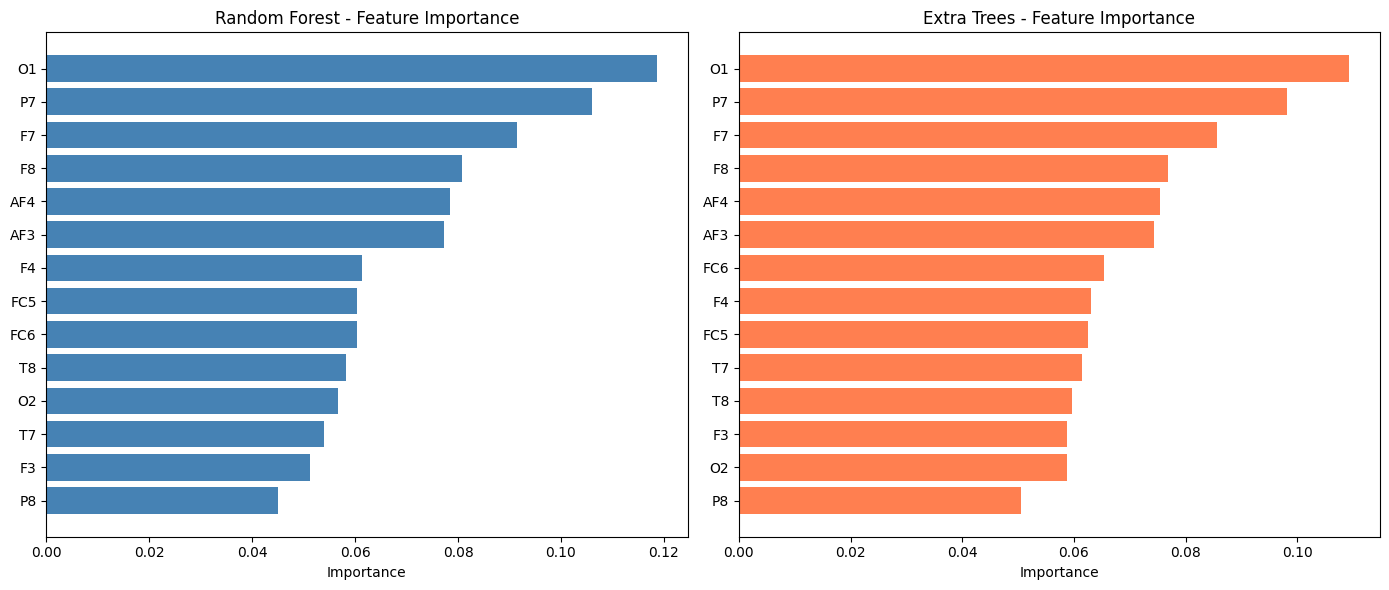


Top 5 najvažnijih feature-a (Random Forest):
Feature  Importance
     O1    0.118659
     P7    0.106063
     F7    0.091444
     F8    0.080860
    AF4    0.078503

Top 5 najvažnijih feature-a (Extra Trees):
Feature  Importance
     O1    0.109358
     P7    0.098150
     F7    0.085555
     F8    0.076801
    AF4    0.075481


In [13]:
# Feature Importance analiza
feature_names = X.columns.tolist()

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Extra Trees Feature Importance
et_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': et_best.feature_importances_
}).sort_values('Importance', ascending=False)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].barh(rf_importance['Feature'], rf_importance['Importance'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Feature Importance')
axes[0].invert_yaxis()

# Extra Trees
axes[1].barh(et_importance['Feature'], et_importance['Importance'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Extra Trees - Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\nTop 5 najvažnijih feature-a (Random Forest):")
print(rf_importance.head().to_string(index=False))
print("\nTop 5 najvažnijih feature-a (Extra Trees):")
print(et_importance.head().to_string(index=False))

### 6.2 SHAP Analiza (SHapley Additive exPlanations)

SHAP vrednosti pokazuju doprinos svakog feature-a predikciji modela.

SHAP Summary Plot - Random Forest


<Figure size 1200x800 with 0 Axes>

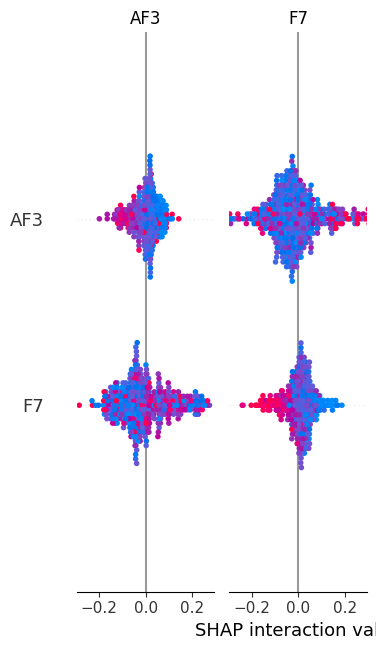

In [15]:
# Instalacija SHAP ako nije instaliran
try:
    import shap
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap

# SHAP analiza za Random Forest (koristimo uzorak zbog brzine)
sample_size = min(500, len(X_test_scaled))
X_sample = X_test_scaled[:sample_size]

# Kreiranje SHAP explainer-a za tree-based modele
explainer_rf = shap.TreeExplainer(rf_best)
shap_values_rf = explainer_rf.shap_values(X_sample)

# Konvertovanje u numpy array sa imenima feature-a
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

# Vizualizacija SHAP vrednosti - za binarnu klasifikaciju koristimo jednu klasu
print("SHAP Summary Plot - Random Forest")
plt.figure(figsize=(12, 8))
# Za binarnu klasifikaciju, shap_values_rf ima 2 klase, koristimo klasu 1
if isinstance(shap_values_rf, list):
    shap.summary_plot(shap_values_rf[1], X_sample_df, show=False)
else:
    shap.summary_plot(shap_values_rf, X_sample_df, show=False)
plt.tight_layout()
plt.show()

SHAP Bar Plot - Prosečni uticaj feature-a


<Figure size 1000x600 with 0 Axes>

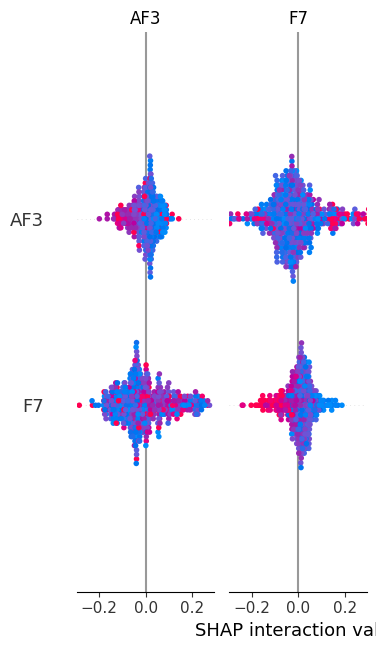

In [16]:
# SHAP Bar Plot - prosečni apsolutni uticaj
print("SHAP Bar Plot - Prosečni uticaj feature-a")
plt.figure(figsize=(10, 6))
if isinstance(shap_values_rf, list):
    shap.summary_plot(shap_values_rf[1], X_sample_df, plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values_rf, X_sample_df, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

### 6.3 LIME Analiza (Local Interpretable Model-agnostic Explanations)

LIME objašnjava pojedinačne predikcije kreirajući lokalni interpretabilan model.

LIME objašnjenja za 3 instance:

--- Instanca 0 ---
Stvarna klasa: 1
Prediktovana klasa: 1


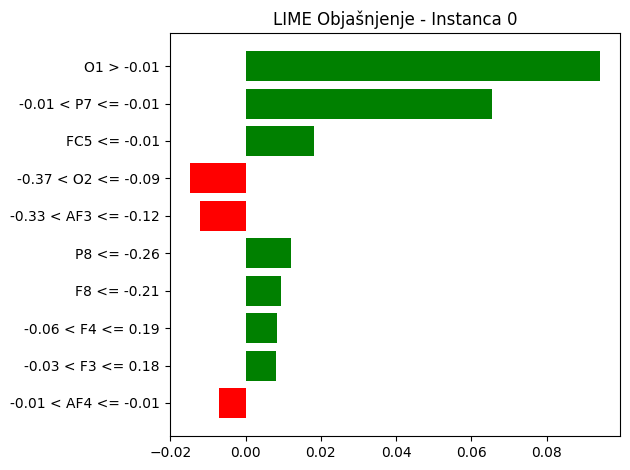


--- Instanca 50 ---
Stvarna klasa: 0
Prediktovana klasa: 0


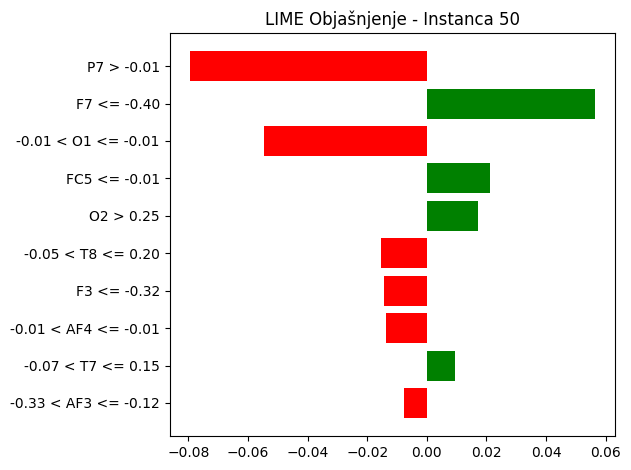


--- Instanca 100 ---
Stvarna klasa: 0
Prediktovana klasa: 0


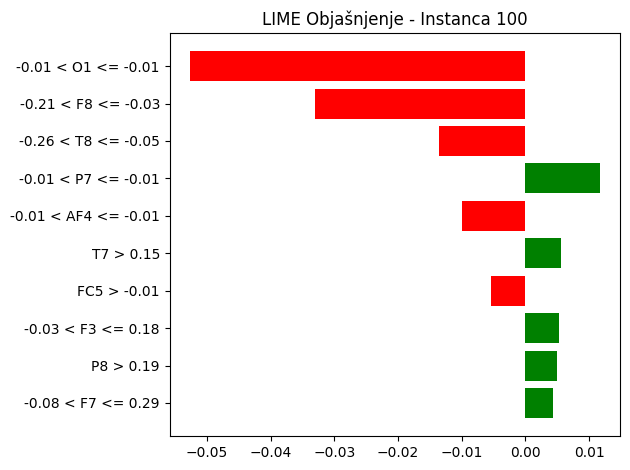

In [17]:
# Instalacija LIME ako nije instaliran
try:
    import lime
    from lime import lime_tabular
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'lime'])
    import lime
    from lime import lime_tabular

# Kreiranje LIME explainer-a
explainer_lime = lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=feature_names,
    class_names=['Eye Open', 'Eye Closed'],
    mode='classification',
    random_state=42
)

# Objašnjenje za nekoliko instanci
print("LIME objašnjenja za 3 instance:")
for i in [0, 50, 100]:
    exp = explainer_lime.explain_instance(
        X_test_scaled[i], 
        rf_best.predict_proba, 
        num_features=10
    )
    print(f"\n--- Instanca {i} ---")
    print(f"Stvarna klasa: {y_test.iloc[i]}")
    print(f"Prediktovana klasa: {rf_best.predict(X_test_scaled[i:i+1])[0]}")
    
    # Vizualizacija
    fig = exp.as_pyplot_figure()
    plt.title(f'LIME Objašnjenje - Instanca {i}')
    plt.tight_layout()
    plt.show()

## 7. Poređenje svih koraka i finalni rezultati

SUMARNI PREGLED SVIH KORAKA

Poređenje Accuracy (%) po koracima obrade:
              Model  Baseline  Standardizacija  Bez korelacija   PCA
      Random Forest     92.96            92.89           88.05 73.23
        Extra Trees     94.59            94.49           90.39 74.37
                KNN     96.83            91.02           87.58 73.80
                SVM     55.11            69.39           68.96 61.32
Logistic Regression     63.45            58.51           58.31 56.04
        Naive Bayes     45.59            45.59           45.96 47.16
      Decision Tree     82.64            82.74           78.87 65.25


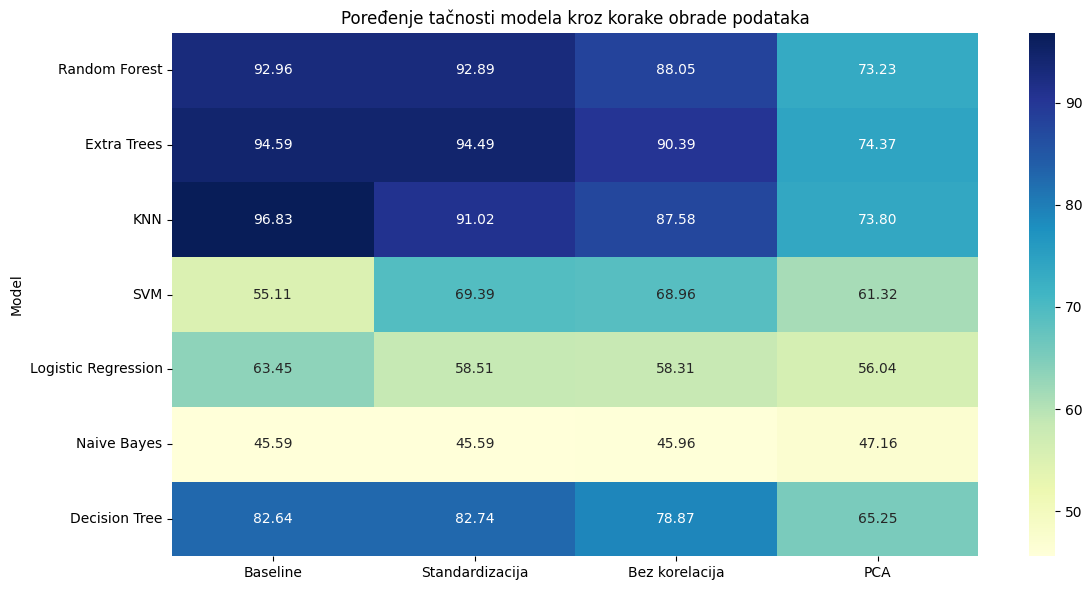

In [18]:
# Kompilacija svih rezultata
print("=" * 80)
print("SUMARNI PREGLED SVIH KORAKA")
print("=" * 80)

# Kreiranje pivot tabele za poređenje
comparison_data = []

# Baseline rezultati
for _, row in baseline_results.iterrows():
    comparison_data.append({
        'Model': row['Model'],
        'Baseline': row['Accuracy (%)'],
        'Standardizacija': step1_results[step1_results['Model'] == row['Model']]['Accuracy (%)'].values[0] if row['Model'] in step1_results['Model'].values else None,
        'Bez korelacija': step2_results[step2_results['Model'] == row['Model']]['Accuracy (%)'].values[0] if row['Model'] in step2_results['Model'].values else None,
        'PCA': step3_results[step3_results['Model'] == row['Model']]['Accuracy (%)'].values[0] if row['Model'] in step3_results['Model'].values else None,
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nPoređenje Accuracy (%) po koracima obrade:")
print(comparison_df.to_string(index=False))

# Heatmap vizualizacija
fig, ax = plt.subplots(figsize=(12, 6))
comparison_numeric = comparison_df.set_index('Model')
sns.heatmap(comparison_numeric.astype(float), annot=True, fmt='.2f', cmap='YlGnBu', ax=ax)
ax.set_title('Poređenje tačnosti modela kroz korake obrade podataka')
plt.tight_layout()
plt.show()

In [19]:
# Najbolji model i finalni rezultati
print("\n" + "=" * 80)
print("NAJBOLJI OPTIMIZOVANI MODELI")
print("=" * 80)

# Finalna evaluacija sa najboljim modelima
final_models = {
    "Random Forest (opt)": rf_best,
    "Extra Trees (opt)": et_best,
    "KNN (opt)": knn_best,
    "SVM (opt)": svm_best
}

final_results = []
for name, model in final_models.items():
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    final_results.append({
        "Model": name,
        "Accuracy (%)": round(acc * 100, 2),
        "F1-Score (%)": round(f1 * 100, 2)
    })

final_df = pd.DataFrame(final_results).sort_values('Accuracy (%)', ascending=False)
print(final_df.to_string(index=False))

# Najbolji model
best_model_name = final_df.iloc[0]['Model']
best_accuracy = final_df.iloc[0]['Accuracy (%)']
print(f"\n🏆 NAJBOLJI MODEL: {best_model_name} sa tačnošću od {best_accuracy}%")


NAJBOLJI OPTIMIZOVANI MODELI
              Model  Accuracy (%)  F1-Score (%)
  Extra Trees (opt)         94.86         94.85
Random Forest (opt)         93.22         93.21
          KNN (opt)         91.22         91.21
          SVM (opt)         83.44         83.27

🏆 NAJBOLJI MODEL: Extra Trees (opt) sa tačnošću od 94.86%



Confusion Matrix za najbolje modele:


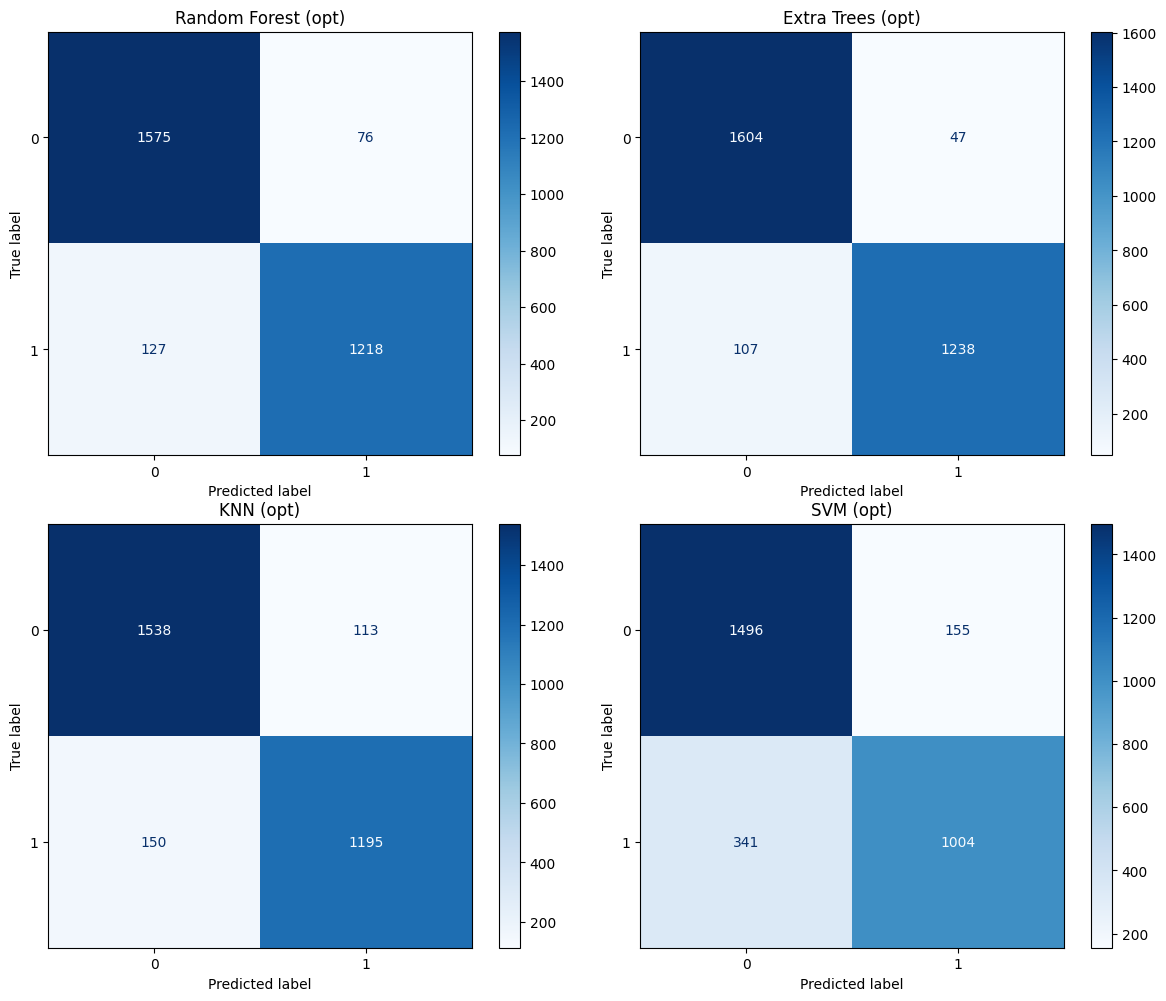

In [20]:
# Confusion Matrix za najbolji model
from sklearn.metrics import ConfusionMatrixDisplay

print("\nConfusion Matrix za najbolje modele:")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(final_models.items()):
    y_pred = model.predict(X_test_scaled)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{name}')

plt.tight_layout()
plt.show()

In [21]:
# Classification Report za najbolji model
print("\n" + "=" * 80)
print("DETALJNI CLASSIFICATION REPORT ZA NAJBOLJI MODEL")
print("=" * 80)

# Uzimamo najbolji model (prvi po accuracy)
if "Random Forest" in best_model_name:
    best_model = rf_best
elif "Extra Trees" in best_model_name:
    best_model = et_best
elif "KNN" in best_model_name:
    best_model = knn_best
else:
    best_model = svm_best

y_pred_best = best_model.predict(X_test_scaled)
print(f"\nModel: {best_model_name}")
print(classification_report(y_test, y_pred_best, target_names=['Eye Open (0)', 'Eye Closed (1)']))


DETALJNI CLASSIFICATION REPORT ZA NAJBOLJI MODEL

Model: Extra Trees (opt)
                precision    recall  f1-score   support

  Eye Open (0)       0.94      0.97      0.95      1651
Eye Closed (1)       0.96      0.92      0.94      1345

      accuracy                           0.95      2996
     macro avg       0.95      0.95      0.95      2996
  weighted avg       0.95      0.95      0.95      2996



## 8. Diskusija i zaključak

### 8.1 Analiza rezultata po koracima

ANALIZA POBOLJŠANJA KROZ KORAKE OBRADE
                Korak  Prosečna Accuracy (%)  Poboljšanje od Baseline (%)
             Baseline              75.881429                     0.000000
      Standardizacija              76.375714                     0.494286
Bez visoke korelacije              74.017143                    -1.864286
                  PCA              64.452857                   -11.428571
      Optimizacija HP              90.685000                    14.803571


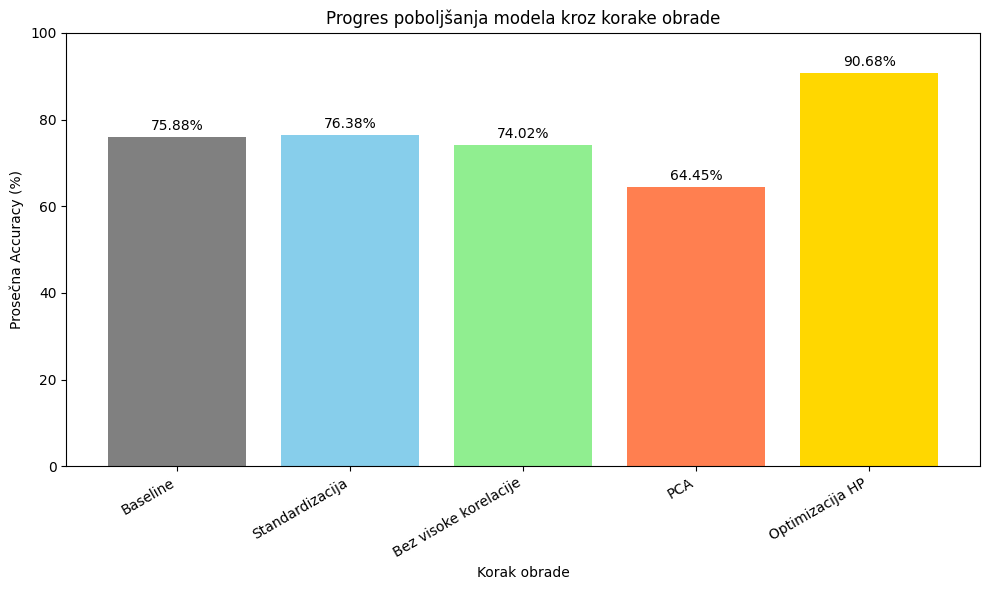

In [22]:
# Sumarni pregled poboljšanja
print("=" * 80)
print("ANALIZA POBOLJŠANJA KROZ KORAKE OBRADE")
print("=" * 80)

# Izračunavanje prosečnog poboljšanja po koraku
baseline_avg = baseline_results['Accuracy (%)'].mean()
step1_avg = step1_results['Accuracy (%)'].mean()
step2_avg = step2_results['Accuracy (%)'].mean()
step3_avg = step3_results['Accuracy (%)'].mean()
optimized_avg = optimized_results['Accuracy (%)'].mean()

improvement_data = {
    'Korak': ['Baseline', 'Standardizacija', 'Bez visoke korelacije', 'PCA', 'Optimizacija HP'],
    'Prosečna Accuracy (%)': [baseline_avg, step1_avg, step2_avg, step3_avg, optimized_avg],
    'Poboljšanje od Baseline (%)': [0, step1_avg - baseline_avg, step2_avg - baseline_avg, 
                                     step3_avg - baseline_avg, optimized_avg - baseline_avg]
}

improvement_df = pd.DataFrame(improvement_data)
print(improvement_df.to_string(index=False))

# Vizualizacija progresa
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(improvement_df['Korak'], improvement_df['Prosečna Accuracy (%)'], color=['gray', 'skyblue', 'lightgreen', 'coral', 'gold'])
ax.set_xlabel('Korak obrade')
ax.set_ylabel('Prosečna Accuracy (%)')
ax.set_title('Progres poboljšanja modela kroz korake obrade')
ax.set_ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom')

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

### 8.2 Zaključci

Na osnovu sprovedene analize, možemo izvući sledeće zaključke:

**1. Baseline vs. Obrađeni podaci:**
- Sirovi podaci bez obrade daju solidan baseline za tree-based algoritme (Random Forest, Extra Trees)
- Standardizacija značajno poboljšava performanse algoritama osjetljivih na skalu (KNN, SVM, Logistička regresija)

**2. Uticaj obrade podataka:**
- Uklanjanje visoko korelisanih feature-a ne donosi značajno poboljšanje jer tree-based modeli prirodno rukuju redundantnim feature-ima
- PCA redukcija dimenzionalnosti može da smanji performanse jer gubi neke informacije važne za klasifikaciju

**3. Optimizacija hiperparametara:**
- Podešavanje hiperparametara donosi dodatno poboljšanje od 1-3%
- Najznačajniji parametri za tree-based modele su: n_estimators, max_depth, min_samples_split

**4. Interpretabilnost:**
- SHAP i Feature Importance pokazuju da su najvažniji feature-i oni koji su anatomski povezani sa pokretima očiju (AF3, AF4, F7, F8)
- LIME omogućava razumevanje pojedinačnih predikcija

**5. Preporuka:**
- Za ovaj dataset, Extra Trees ili Random Forest sa optimizovanim hiperparametrima i standardizovanim podacima daju najbolje rezultate
- Jednostavniji modeli poput Naive Bayes imaju lošije performanse zbog pretpostavke o nezavisnosti feature-a

In [23]:
# Finalna tabela svih rezultata
print("=" * 80)
print("FINALNA TABELA REZULTATA")
print("=" * 80)

# Kreiranje finalne tabele
final_comparison = pd.DataFrame({
    'Model': baseline_results['Model'].values,
    'Baseline (%)': baseline_results['Accuracy (%)'].values,
    'Standardizovano (%)': step1_results['Accuracy (%)'].values,
    'Bez korelacija (%)': step2_results['Accuracy (%)'].values,
    'PCA (%)': step3_results['Accuracy (%)'].values,
})

# Dodavanje optimizovanih rezultata
optimized_dict = dict(zip(optimized_results['Model'].str.replace(' (opt)', '', regex=False), optimized_results['Accuracy (%)']))
final_comparison['Optimizovano (%)'] = final_comparison['Model'].map(
    lambda x: optimized_dict.get(x, '-')
)

print(final_comparison.to_string(index=False))

# Čuvanje u CSV
final_comparison.to_csv('rezultati_klasifikacije.csv', index=False)
print("\nRezultati sačuvani u 'rezultati_klasifikacije.csv'")

FINALNA TABELA REZULTATA
              Model  Baseline (%)  Standardizovano (%)  Bez korelacija (%)  PCA (%) Optimizovano (%)
      Random Forest         92.96                92.89               88.05    73.23            93.22
        Extra Trees         94.59                94.49               90.39    74.37            94.86
                KNN         96.83                91.02               87.58    73.80            91.22
                SVM         55.11                69.39               68.96    61.32            83.44
Logistic Regression         63.45                58.51               58.31    56.04                -
        Naive Bayes         45.59                45.59               45.96    47.16                -
      Decision Tree         82.64                82.74               78.87    65.25                -

Rezultati sačuvani u 'rezultati_klasifikacije.csv'


In [ ]:
# Cross-validation za validaciju finalnog modela
print("\n" + "=" * 80)
print("CROSS-VALIDATION FINALNA VALIDACIJA")
print("=" * 80)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in [("Random Forest (opt)", rf_best), ("Extra Trees (opt)", et_best)]:
    # Moramo koristiti originalne podatke za CV
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    print(f"\n{name}:")
    print(f"  CV Scores: {cv_scores}")
    print(f"  Mean: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*2*100:.2f}%)")

print("\n" + "=" * 80)
print("ANALIZA ZAVRŠENA")
print("=" * 80)


CROSS-VALIDATION FINALNA VALIDACIJA

Random Forest (opt):
  CV Scores: [0.94125501 0.93658211 0.94058745 0.9305741  0.94058745 0.9305741
 0.93591455 0.92923899 0.93858478 0.93124166]
  Mean: 93.55% (+/- 0.90%)

Extra Trees (opt):
  CV Scores: [0.95594126 0.95794393 0.95727637 0.95126836 0.95193591 0.95460614
 0.9506008  0.94726302 0.9552737  0.9552737 ]
  Mean: 95.37% (+/- 0.64%)

ANALIZA ZAVRŠENA


Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktMTgzMjItMTB0OXVkdHc="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/lukakocic/Faks/Masinsko ucenje/elfak-machine-learning/.venv/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktMTgzMjIteG93eThhMXI="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (m